## Objective: To redo the comparison of electrostatics on solved versus modeled structures

I previously downloaded all the structures annotated in the ThSAbDab from the protein data bank. I then 'fixed' the structures by removing unwanted chains and fixing internal residues. Next I ran the descriptor code to calculate the electrostatic descriptors. This resulted in descriptor values that were very different from the ones that I calculated using the predicted strucutures. 

In predicting the strucutures from sequence, I only used the Fv region as per the descriptor paper. For the solved structure I used the Fc and Fv I beleive. 

Here, I am redoing the calculations and the anlysis. 

#### Load modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm 
import nglview as nv
from abnumber import Chain as AbChain
from Bio.Align import PairwiseAligner
from Bio.PDB.Superimposer import Superimposer
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import PDBIO

import warnings
warnings.filterwarnings("ignore")

from developability.utils import ls, extract_sequence_from_pdb, determine_chain_type
from developability.pipeline import run_processing_pipeline
from developability.pdb_tools import extract_fv_from_pdb, fix_antibody

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

#### Set up paths and load summaries/metadata

In [2]:
data_path = Path("/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies")
downloaded_pdbs = data_path/'solved_therapeutic_abs'
ls(data_path, True)


['ab_summaries.csv',
 'Biophysical:Chemical data for abs',
 '.DS_Store',
 'AbodyBuilder2_predicted_renumbered_stuctures',
 'ABodyBuilder2_predicted_structures',
 'solved_protein_electrostatics',
 'HeavyLightChainAbPdbs',
 'fv_only_pbds',
 'TSAbDb.csv',
 'aligned_antibodies',
 'therapeutic_antibodies.csv',
 'solved_therapeutic_abs',
 'solved_structure_descriptors_11-07-23.csv']

In [3]:
sum_df = pd.read_csv(data_path/'ab_summaries.csv')
# select xray-crystalls only
print(f'Total number pdbs is {len(sum_df)}')
sum_df = sum_df.query('method=="X-RAY DIFFRACTION"')
# dedupe based on pdb
sum_df = sum_df.drop_duplicates(subset = ['pdb'])
print(f'Number of unique pdbs for x-ray diffraction is {len(sum_df)}')

sum_df = (sum_df.sort_values(['antibody', 'resolution'])
          .drop_duplicates(subset ='antibody')
          )
print(f'Number of pdbs of unique antibodies for x-ray diffraction is {len(sum_df)}.')

sum_df.head()

Total number pdbs is 2146
Number of unique pdbs for x-ray diffraction is 462
Number of pdbs of unique antibodies for x-ray diffraction is 204.


antibody   pdb Hchain Lchain  model antigen_chain antigen_type  \
1     abelacimab  6r8x      C      B    0.0             A      protein   
2      acimtamig  7seg      H      L    0.0             C      protein   
4     adalimumab  6cr1      H      L    0.0           NaN          NaN   
10  adintrevimab  7u2d      H      L    0.0             A      protein   
12    aducanumab  6cnr      H      L    0.0           NaN          NaN   

   antigen_het_name                                       antigen_name  \
1               NaN                              coagulation factor xi   
2               NaN  low affinity immunoglobulin gamma fc region re...   
4               NaN                                                NaN   
10              NaN                                   spike protein s1   
12              NaN                                                NaN   

                   short_header      date  \
1                BLOOD CLOTTING  04/02/19   
2             ANTITUMOR PROTEIN  09/30/21   
4                 IMMUNE SYSTEM  03/16/18   
10  VIRAL PROTEIN/IMMUNE SYSTEM  02/23/22   
12                IMMUNE SYSTEM  03/08/18   

                                             compound  \
1   COAGULATION FACTOR XI CATALYTIC DOMAIN IN COMP...   
2   Crystal structure of the complex of CD16A boun...   
4                                     adalimumab EFab   
10  Crystal structure of SARS-CoV-2 receptor bindi...   
12                                 aducanumab apo Fab   

                                             organism heavy_species  \
1                          HOMO SAPIENS; UNIDENTIFIED  unidentified   
2                                        HOMO SAPIENS  homo sapiens   
4                                        HOMO SAPIENS  homo sapiens   
10  SEVERE ACUTE RESPIRATORY SYNDROME CORONAVIRUS ...  homo sapiens   
12                                       HOMO SAPIENS  homo sapiens   

   light_species                                  antigen_species  \
1   unidentified                                     homo sapiens   
2   homo sapiens                                     homo sapiens   
4   homo sapiens                                              NaN   
10  homo sapiens  severe acute respiratory syndrome coronavirus2    
12  homo sapiens                                              NaN   

                                        authors  resolution  \
1                       Schiering, N., Koch, A.       2.040   
2   Kiefer, J.R., Wallweber, H.A., Polson, A.G.       2.156   
4                                   Arndt, J.W.       1.521   
10              Zhu, X., Yuan, M., Wilson, I.A.       2.760   
12                                  Arndt, J.W.       2.090   

               method r_free r_factor   scfv engineered heavy_subclass  \
1   X-RAY DIFFRACTION  0.282     0.22  False       True          IGHV3   
2   X-RAY DIFFRACTION  0.234    0.189  False       True          IGHV1   
4   X-RAY DIFFRACTION  0.179    0.153  False       True          IGHV3   
10  X-RAY DIFFRACTION  0.259     0.22  False       True          IGHV3   
12  X-RAY DIFFRACTION  0.239    0.211  False       True          IGHV3   

   light_subclass light_ctype  affinity  delta_g affinity_method  temperature  \
1           IGLV1      Lambda       NaN      NaN             NaN          NaN   
2           IGLV3      Lambda       NaN      NaN             NaN          NaN   
4           IGKV1       Kappa       NaN      NaN             NaN          NaN   
10          IGLV1      Lambda       NaN      NaN             NaN          NaN   
12          IGKV1       Kappa       NaN      NaN             NaN          NaN   

    pmid <!doctype html>  
1    NaN             NaN  
2    NaN             NaN  
4    NaN             NaN  
10   NaN             NaN  
12   NaN             NaN

##### Load the results for the predicted structures and previous solved

In [4]:
renumbered_ab_dir = data_path/'AbodyBuilder2_predicted_renumbered_stuctures'
predicted_descriptors_df = pd.read_csv(renumbered_ab_dir/'antibody_descriptor_results.csv')

old_solved_descriptors_df = (pd.read_parquet(data_path/'solved_structure_descriptors_11-07-23.csv')
                             
                             )

predicted_descriptors_df.head()

antibody  Heparin  FcRn  HCDR1_APBS_pos  HCDR1_APBS_neg  HCDR1_APBS_net  \
0   adalimumab     0.79  1.04      361.422343     -794.503791     -433.081449   
1   daclizumab     0.84  0.02     4252.553904        0.000000     4252.553904   
2    ganitumab     0.79  3.20     1818.147090        0.000000     1818.147090   
3  vedolizumab     0.54  0.23        0.000000    -2649.100853    -2649.100853   
4  natalizumab     0.54  0.27      972.583337      -97.200479      875.382858   

   HCDR2_APBS_pos  HCDR2_APBS_neg  HCDR2_APBS_net  HCDR3_APBS_pos  \
0     1555.624126    -4014.715450    -2459.091324     2875.086488   
1     4452.876492     -904.794295     3548.082197     3911.936888   
2     6910.914448        0.000000     6910.914448     2961.303964   
3     4492.540426    -5860.854936    -1368.314511        0.000000   
4    11200.435647     -312.532150    10887.903497     5410.511420   

   HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  HFR1_APBS_neg  \
0     -138.003294     2737.083194    5376.458039   -1771.257720   
1        0.000000     3911.936888   14311.015341    -193.586163   
2     -484.904947     2476.399018   10333.605343    -525.798048   
3    -6989.631169    -6989.631169    6391.205916    -986.398297   
4        0.000000     5410.511420   16469.362126    -162.325666   

   HFR1_APBS_net  HFR2_APBS_pos  HFR2_APBS_neg  HFR2_APBS_net  HFR3_APBS_pos  \
0    3605.200319    2726.475633    -584.411432    2142.064200    3398.963679   
1   14117.429178    1868.888108     -38.688851    1830.199256    4672.451210   
2    9807.807295    2872.797423    -281.600949    2591.196475   11761.616999   
3    5404.807619    3360.681228       0.000000    3360.681228    3163.553567   
4   16307.036460    5172.353262       0.000000    5172.353262    7039.283850   

   HFR3_APBS_neg  HFR3_APBS_net  HFR4_APBS_pos  HFR4_APBS_neg  HFR4_APBS_net  \
0   -1368.871898    2030.091781     905.524940    -973.487817     -67.962877   
1    -414.558541    4257.892669    1996.455362    -125.736264    1870.719098   
2    -147.382398   11614.234601     360.371905   -1259.033101    -898.661196   
3   -2239.208472     924.345095     306.504321   -1241.789054    -935.284733   
4    -181.734569    6857.549282    2097.229021    -182.749645    1914.479376   

   LCDR1_APBS_pos  LCDR1_APBS_neg  LCDR1_APBS_net  LCDR2_APBS_pos  \
0     7088.950311       -2.623292     7086.327019     1842.767512   
1     2912.056050     -214.503158     2697.552891     2848.982419   
2     4405.906664     -170.769361     4235.137303     2334.634695   
3     3087.786259     -636.602461     2451.183798      509.924516   
4     4184.768499     -140.461723     4044.306775     2837.599448   

   LCDR2_APBS_neg  LCDR2_APBS_net  LCDR3_APBS_pos  LCDR3_APBS_neg  \
0        0.000000     1842.767512     3232.607354      -34.553594   
1        0.000000     2848.982419     6021.840255        0.000000   
2        0.000000     2334.634695     1148.865688     -288.326494   
3    -1506.710115     -996.785599      832.881116    -1176.577647   
4        0.000000     2837.599448     3006.425840     -417.500166   

   LCDR3_APBS_net  LFR1_APBS_pos  LFR1_APBS_neg  LFR1_APBS_net  LFR2_APBS_pos  \
0     3198.053760    5204.403827    -935.352752    4269.051075    6533.142402   
1     6021.840255    3227.953846   -1014.915103    2213.038743   10027.781235   
2      860.539194    3364.619614   -1193.814546    2170.805067     620.200783   
3     -343.696531    3533.941961   -2778.369692     755.572269     388.298819   
4     2588.925674    8047.530743    -694.678048    7352.852695    7260.686909   

   LFR2_APBS_neg  LFR2_APBS_net  LFR3_APBS_pos  LFR3_APBS_neg  LFR3_APBS_net  \
0     -21.319271    6511.823132    6140.552634    -104.698825    6035.853809   
1       0.000000   10027.781235    8142.327827    -283.031831    7859.295996   
2   -1222.838265    -602.637481    3967.226838   -3170.419029     796.807809   
3   -1733.955582   -1345.656763    2898.969789   -4356.423208   -1457.453419   
4       0.000000    72

##### Identify the subset of ABs with structures and heparin binding data. 

In [5]:
common_antibodies = list(set(predicted_descriptors_df.antibody)
                     .intersection(set(sum_df.antibody))
                     )
common_antibodies.sort()
print(f'There are {len(common_antibodies)} antibodies in the set')

There are 52 antibodies in the set


##### Select metadata for common antibodies only

In [6]:
sum_df = sum_df.query('antibody in @common_antibodies')
predicted_descriptors_df = predicted_descriptors_df.query('antibody in @common_antibodies')
predicted_descriptors_df = (predicted_descriptors_df.set_index('antibody').sort_index())
predicted_descriptors_df.shape

(52, 71)

#### Now for each antibody in common set do calculations. 

This has several steps: 
1. Fix the antibody. 
2. Select the FV region only. 
3. Do the electrostatic calculations. 

In [7]:
fv_path = data_path/'fv_only_pbds'
if not fv_path.exists(): 
    fv_path.mkdir()

In [8]:
pq_name = fv_path/'solved_ab_descriptors_10-18-2023.pq'
if not pq_name.exists():
#if True:
    descriptors = []
    for _, row in tqdm(sum_df.iterrows(), total = len(sum_df)): 
        try:
            filename = f'{row.antibody}_{row.pdb}.pdb'
            ab_file = downloaded_pdbs/ filename
        
            # fix pdb and extract fv
            chains_to_keep = [row.Hchain  , row.Lchain]
            fname = fv_path/filename
            _= fix_antibody(ab_file,chains_to_keep, output_path=fv_path)
            _ = extract_fv_from_pdb(fname, fname)
            res = run_processing_pipeline(fname)
            descriptors.append(res)
        except:
            pass
    solved_descriptors_df = pd.concat(descriptors)
    solved_descriptors_df.to_parquet(pq_name)
else:
    solved_descriptors_df = pd.read_parquet(pq_name)

solved_descriptors_df.index = solved_descriptors_df.index.str.split('_').str.get(0)
solved_descriptors_df = solved_descriptors_df.sort_index()

In [9]:
predicted_descriptors_df.head()

Heparin  FcRn  HCDR1_APBS_pos  HCDR1_APBS_neg  HCDR1_APBS_net  \
antibody                                                                      
adalimumab       0.79  1.04      361.422343     -794.503791     -433.081449   
alemtuzumab      0.70  0.09     1532.439237        0.000000     1532.439237   
anifrolumab      0.48  0.21        0.000000     -781.312151     -781.312151   
atezolizumab     0.53  1.16     1109.424535     -363.371737      746.052798   
bapineuzumab     0.86 -0.02     2103.741269        0.000000     2103.741269   

              HCDR2_APBS_pos  HCDR2_APBS_neg  HCDR2_APBS_net  HCDR3_APBS_pos  \
antibody                                                                       
adalimumab       1555.624126    -4014.715450    -2459.091324     2875.086488   
alemtuzumab     14369.230068        0.000000    14369.230068     4886.091340   
anifrolumab       110.781017    -4464.793967    -4354.012950        0.000000   
atezolizumab     3337.740922     -332.912577     3004.828345     3952.042341   
bapineuzumab    16265.634292     -143.695457    16121.938835     3942.454805   

              HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  HFR1_APBS_neg  \
antibody                                                                     
adalimumab       -138.003294     2737.083194    5376.458039   -1771.257720   
alemtuzumab         0.000000     4886.091340   17280.688445     -27.178419   
anifrolumab     -3400.468767    -3400.468767    5453.781477   -1506.282175   
atezolizumab        0.000000     3952.042341    8228.337816     -47.049744   
bapineuzumab     -702.049033     3240.405772    5396.161636   -1671.302846   

              HFR1_APBS_net  HFR2_APBS_pos  HFR2_APBS_neg  HFR2_APBS_net  \
antibody                                                                   
adalimumab      3605.200319    2726.475633    -584.411432    2142.064200   
alemtuzumab    17253.510027    5702.850968       0.000000    5702.850968   
anifrolumab     3947.499302    2373.240295    -435.781633    1937.458661   
atezolizumab    8181.288071    2993.167778    -370.246945    2622.920833   
bapineuzumab    3724.858790    3227.835057    -153.597498    3074.237559   

              HFR3_APBS_pos  HFR3_APBS_neg  HFR3_APBS_net  HFR4_APBS_pos  \
antibody                                                                   
adalimumab      3398.963679   -1368.871898    2030.091781     905.524940   
alemtuzumab    14492.146977       0.000000   14492.146977    2177.378996   
anifrolumab     3650.672549    -899.184853    2751.487696    1645.122573   
atezolizumab    7874.434772    -522.028769    7352.406003    2554.022509   
bapineuzumab    9598.906104    -636.548435    8962.357669     278.605121   

              HFR4_APBS_neg  HFR4_APBS_net  LCDR1_APBS_pos  LCDR1_APBS_neg  \
antibody                                                                     
adalimumab      -973.487817     -67.962877     7088.950311       -2.623292   
alemtuzumab      -44.267878    2133.111118     5843.170300        0.000000   
anifrolumab     -979.002997     666.119576      809.980411    -1522.379620   
atezolizumab   -1177.530309    1376.492200     1233.303476     -906.242621   
bapineuzumab   -2435.366589   -2156.761468     3805.571239     -552.986078   

              LCDR1_APBS_net  LCDR2_APBS_pos  LCDR2_APBS_neg  LCDR2_APBS_net  \
antibody                                                                       
adalimumab       7086.327019     1842.767512        0.000000     1842.767512   
alemtuzumab      5843.170300     3963.939783        0.000000     3963.939783   
anifrolumab      -712.399209      430.138604     -538.865321     -108.726716   
atezolizumab      327.060855     1500.402823     -122.234735     1378.168088   
bapineuzumab     3252.585161     2187.484085     -889.442136     1298.041948   

              LCDR3_APBS_pos  LCDR3_APBS_neg  LCDR3_APBS_net  LFR1_APBS_pos  \
antibody                                                                      
adalimumab       323

#### Look at the results 

In [10]:
predicted_descriptors_df = (predicted_descriptors_df.query('index in @solved_descriptors_df.index')
                            .sort_index()
                            )
heparin = predicted_descriptors_df['Heparin']

# arrange the old results
old_solved_descriptors_df = (old_solved_descriptors_df.query('index in @solved_descriptors_df.index')
                             .sort_index()
                             )
                             
try:                              
    old_solved_descriptors_df.insert(0, 'Heparin',heparin)
except: 
    pass

# add heparin to new results
try:
    solved_descriptors_df.insert(0, 'Heparin',heparin)
except: 
    pass

# remove zero columns
zeros = (solved_descriptors_df==0).mean()
cols = [col for col in zeros.index if zeros.loc[col]<1]

# correlation
solved_descriptors_df = solved_descriptors_df[cols]
solved_corr = solved_descriptors_df.corr()
solved_corr.head()

Heparin  HCDR1_APBS_pos  HCDR1_APBS_neg  HCDR1_APBS_net  \
Heparin         1.000000        0.690045        0.480237        0.692379   
HCDR1_APBS_pos  0.690045        1.000000        0.536954        0.938104   
HCDR1_APBS_neg  0.480237        0.536954        1.000000        0.795907   
HCDR1_APBS_net  0.692379        0.938104        0.795907        1.000000   
HCDR2_APBS_pos  0.635443        0.623428        0.462929        0.637465   

                HCDR2_APBS_pos  HCDR2_APBS_neg  HCDR2_APBS_net  \
Heparin               0.635443        0.498190        0.638402   
HCDR1_APBS_pos        0.623428        0.485335        0.624884   
HCDR1_APBS_neg        0.462929        0.626483        0.576080   
HCDR1_APBS_net        0.637465        0.605511        0.684965   
HCDR2_APBS_pos        1.000000        0.647263        0.947066   

                HCDR3_APBS_pos  HCDR3_APBS_neg  HCDR3_APBS_net  HFR1_APBS_pos  \
Heparin               0.548297        0.451237        0.592192       0.552292   
HCDR1_APBS_pos        0.582345        0.516544        0.644874       0.730599   
HCDR1_APBS_neg        0.388704        0.718383        0.589838       0.540879   
HCDR1_APBS_net        0.577508        0.665639        0.704959       0.746379   
HCDR2_APBS_pos        0.583764        0.429860        0.608924       0.620747   

                HFR1_APBS_neg  HFR1_APBS_net  HFR2_APBS_pos  HFR2_APBS_neg  \
Heparin              0.489758       0.570470       0.426536       0.323655   
HCDR1_APBS_pos       0.470928       0.722533       0.451653       0.436255   
HCDR1_APBS_neg       0.660011       0.591415       0.405681       0.431425   
HCDR1_APBS_net       0.608937       0.761339       0.490686       0.490205   
HCDR2_APBS_pos       0.420567       0.617605       0.652338       0.509088   

                HFR2_APBS_net  HFR3_APBS_pos  HFR3_APBS_neg  HFR3_APBS_net  \
Heparin              0.427617       0.633308       0.501905       0.625564   
HCDR1_APBS_pos       0.493536       0.616773       0.402001       0.581511   
HCDR1_APBS_neg       0.460537       0.533163       0.440546       0.532395   
HCDR1_APBS_net       0.543265       0.661524       0.469368       0.635903   
HCDR2_APBS_pos       0.660129       0.838418       0.549446       0.791436   

                HFR4_APBS_pos  HFR4_APBS_neg  HFR4_APBS_net  LCDR1_APBS_pos  \
Heparin              0.270107       0.413947       0.363680        0.550525   
HCDR1_APBS_pos       0.359538       0.563536       0.489711        0.515548   
HCDR1_APBS_neg       0.303808       0.491405       0.420628        0.448503   
HCDR1_APBS_net       0.382755       0.606174       0.524135        0.554122   
HCDR2_APBS_pos       0.361885       0.428317       0.430633        0.584794   

                LCDR1_APBS_neg  LCDR1_APBS_net  LCDR2_APBS_pos  \
Heparin               0.384116        0.535761        0.573552   
HCDR1_APBS_pos        0.384580        0.515504        0.696120   
HCDR1_APBS_neg        0.567272        0.577427        0.484038   
HCDR1_APBS_net        0.508894        0.607021        0.698298   
HCDR2_APBS_pos        0.412578        0.571633        0.627806   

                LCDR2_APBS_neg  LCDR2_APBS_net  LCDR3_APBS_pos  \
Heparin               0.348055        0.542828        0.683137   
HCDR1_APBS_pos        0.449546        0.670378        0.668272   
HCDR1_APBS_neg        0.526506        0.557258        0.365724   
HCDR1_APBS_net        0.538780        0.709886        0.629738   
HCDR2_APBS_pos        0.426046        0.613372        0.837043   

                LCDR3_APBS_neg  LCDR3_APBS_net  LFR1_APBS_pos  LFR1_APBS_neg  \
Heparin               0.410501        0.668986       0.632775       0.500660   
HCDR1_APBS_pos        0.416554        0.662722       0.530905       0.436669   
HCDR1_APBS_neg        0.692625        0.619822       0.460623       0.562424   
HCDR1_APBS_net        0.583306        0.730078       0.570118       0.544286   
HCDR2_APBS_pos        0.463744        0.797990       0.722442       0

Text(0.5, 1.01, 'Correlation with Relative Heparin Binding for Solved Structures')

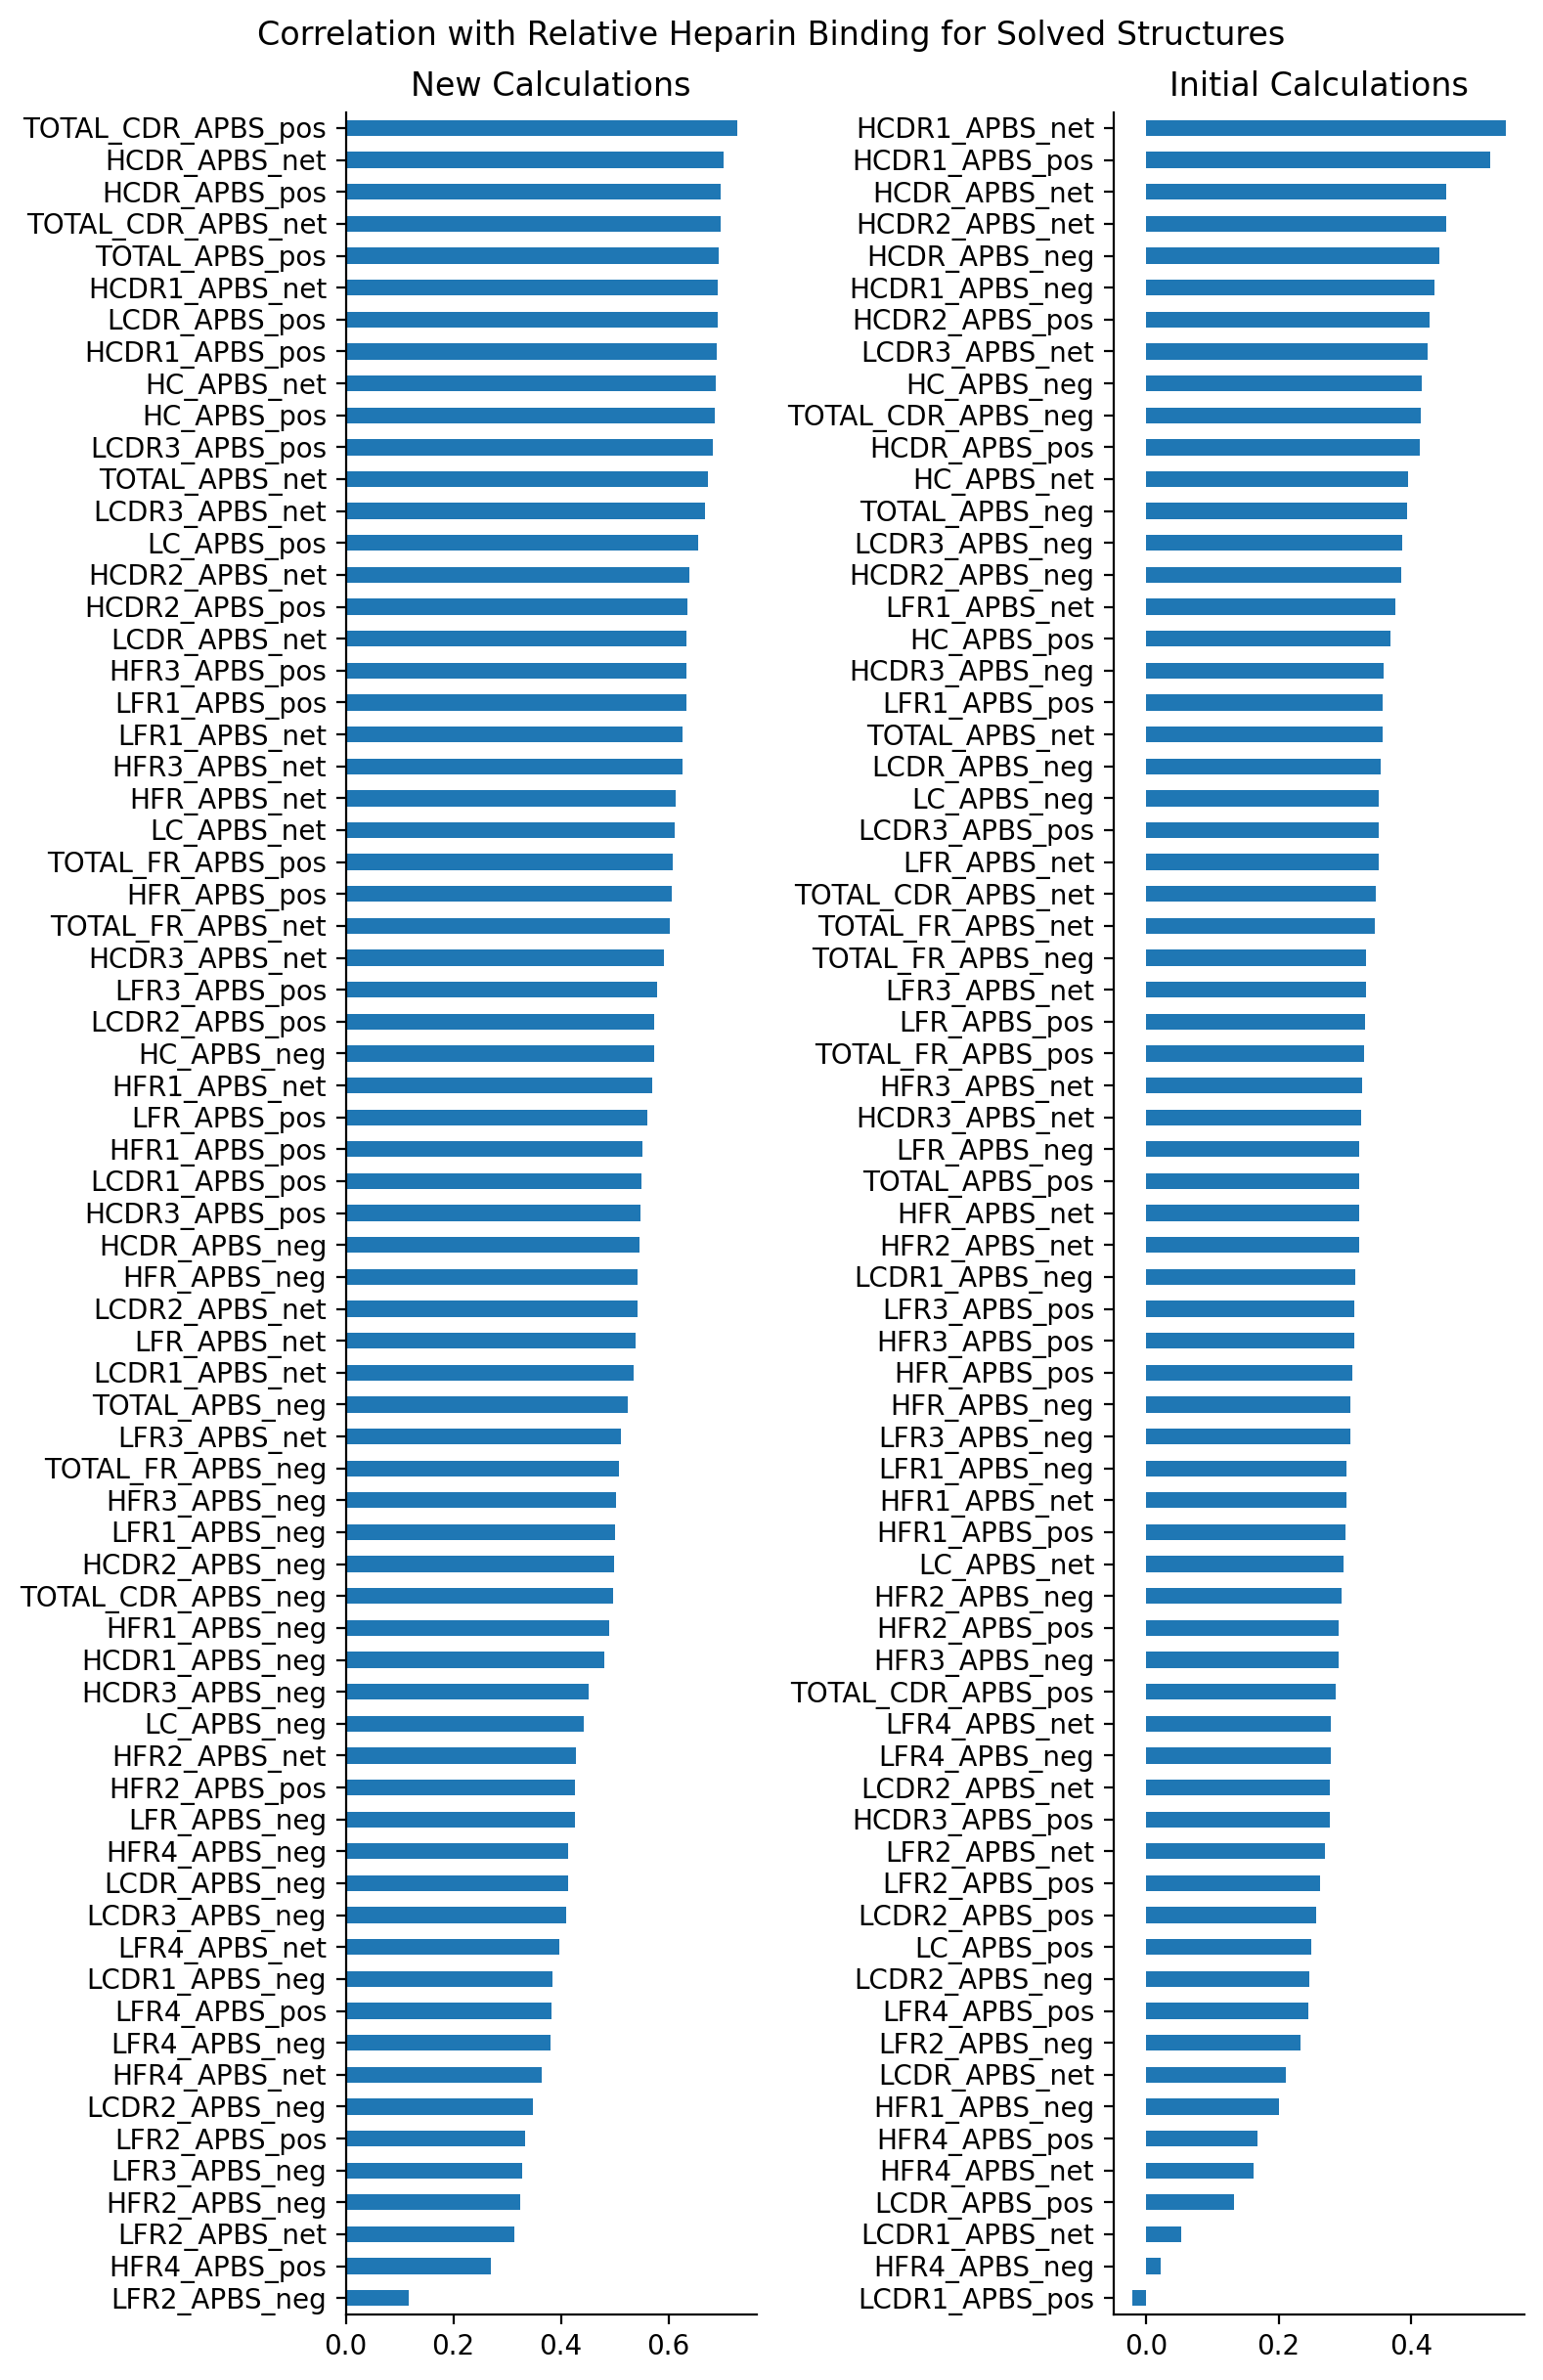

In [11]:
fig, axes = plt.subplots(1,2, figsize =(8, 12))

heparin_corr = (solved_corr.loc['Heparin']
                .sort_values()
                .iloc[:-1]
                )
ax =heparin_corr.plot(kind = 'barh', ax= axes[0])
ax.set(title = 'New Calculations')
sns.despine()

old_corr = old_solved_descriptors_df[cols].corr()
old_heparin_corr = (old_corr.loc['Heparin']
                .sort_values()
                .iloc[:-1]
                )
ax =old_heparin_corr.plot(kind = 'barh', ax= axes[1])
ax.set(title = 'Initial Calculations')
sns.despine()
plt.tight_layout()
fig.suptitle('Correlation with Relative Heparin Binding for Solved Structures',y=1.01 )

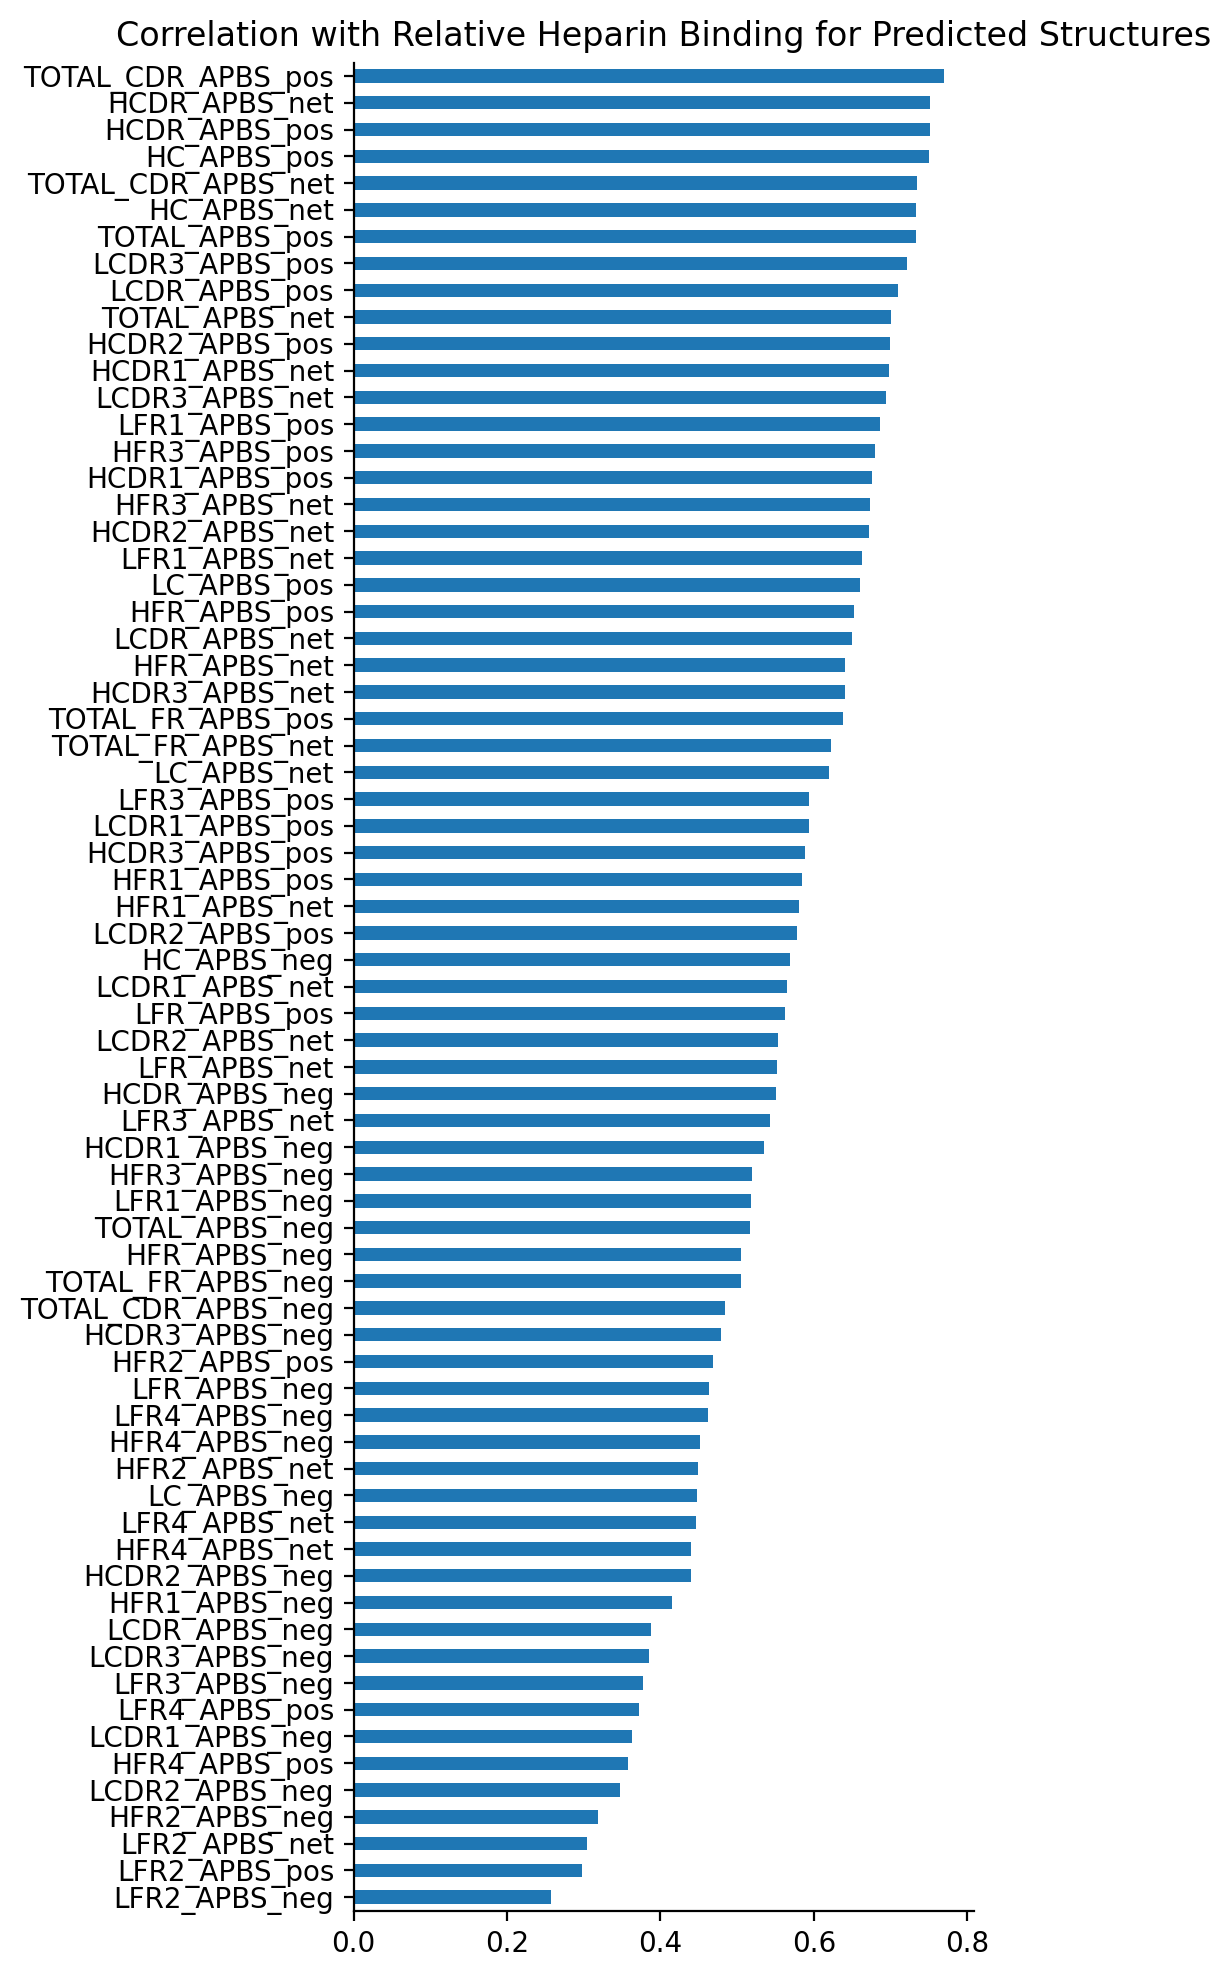

In [12]:
predicted_corr=predicted_descriptors_df[cols].corr()
predicted_heparin_corr = (predicted_corr.loc['Heparin']
                .sort_values()
                .iloc[:-1]
                )
ax =predicted_heparin_corr.plot(kind = 'barh', figsize=(4,12))
ax.set(title = 'Correlation with Relative Heparin Binding for Predicted Structures')
sns.despine()

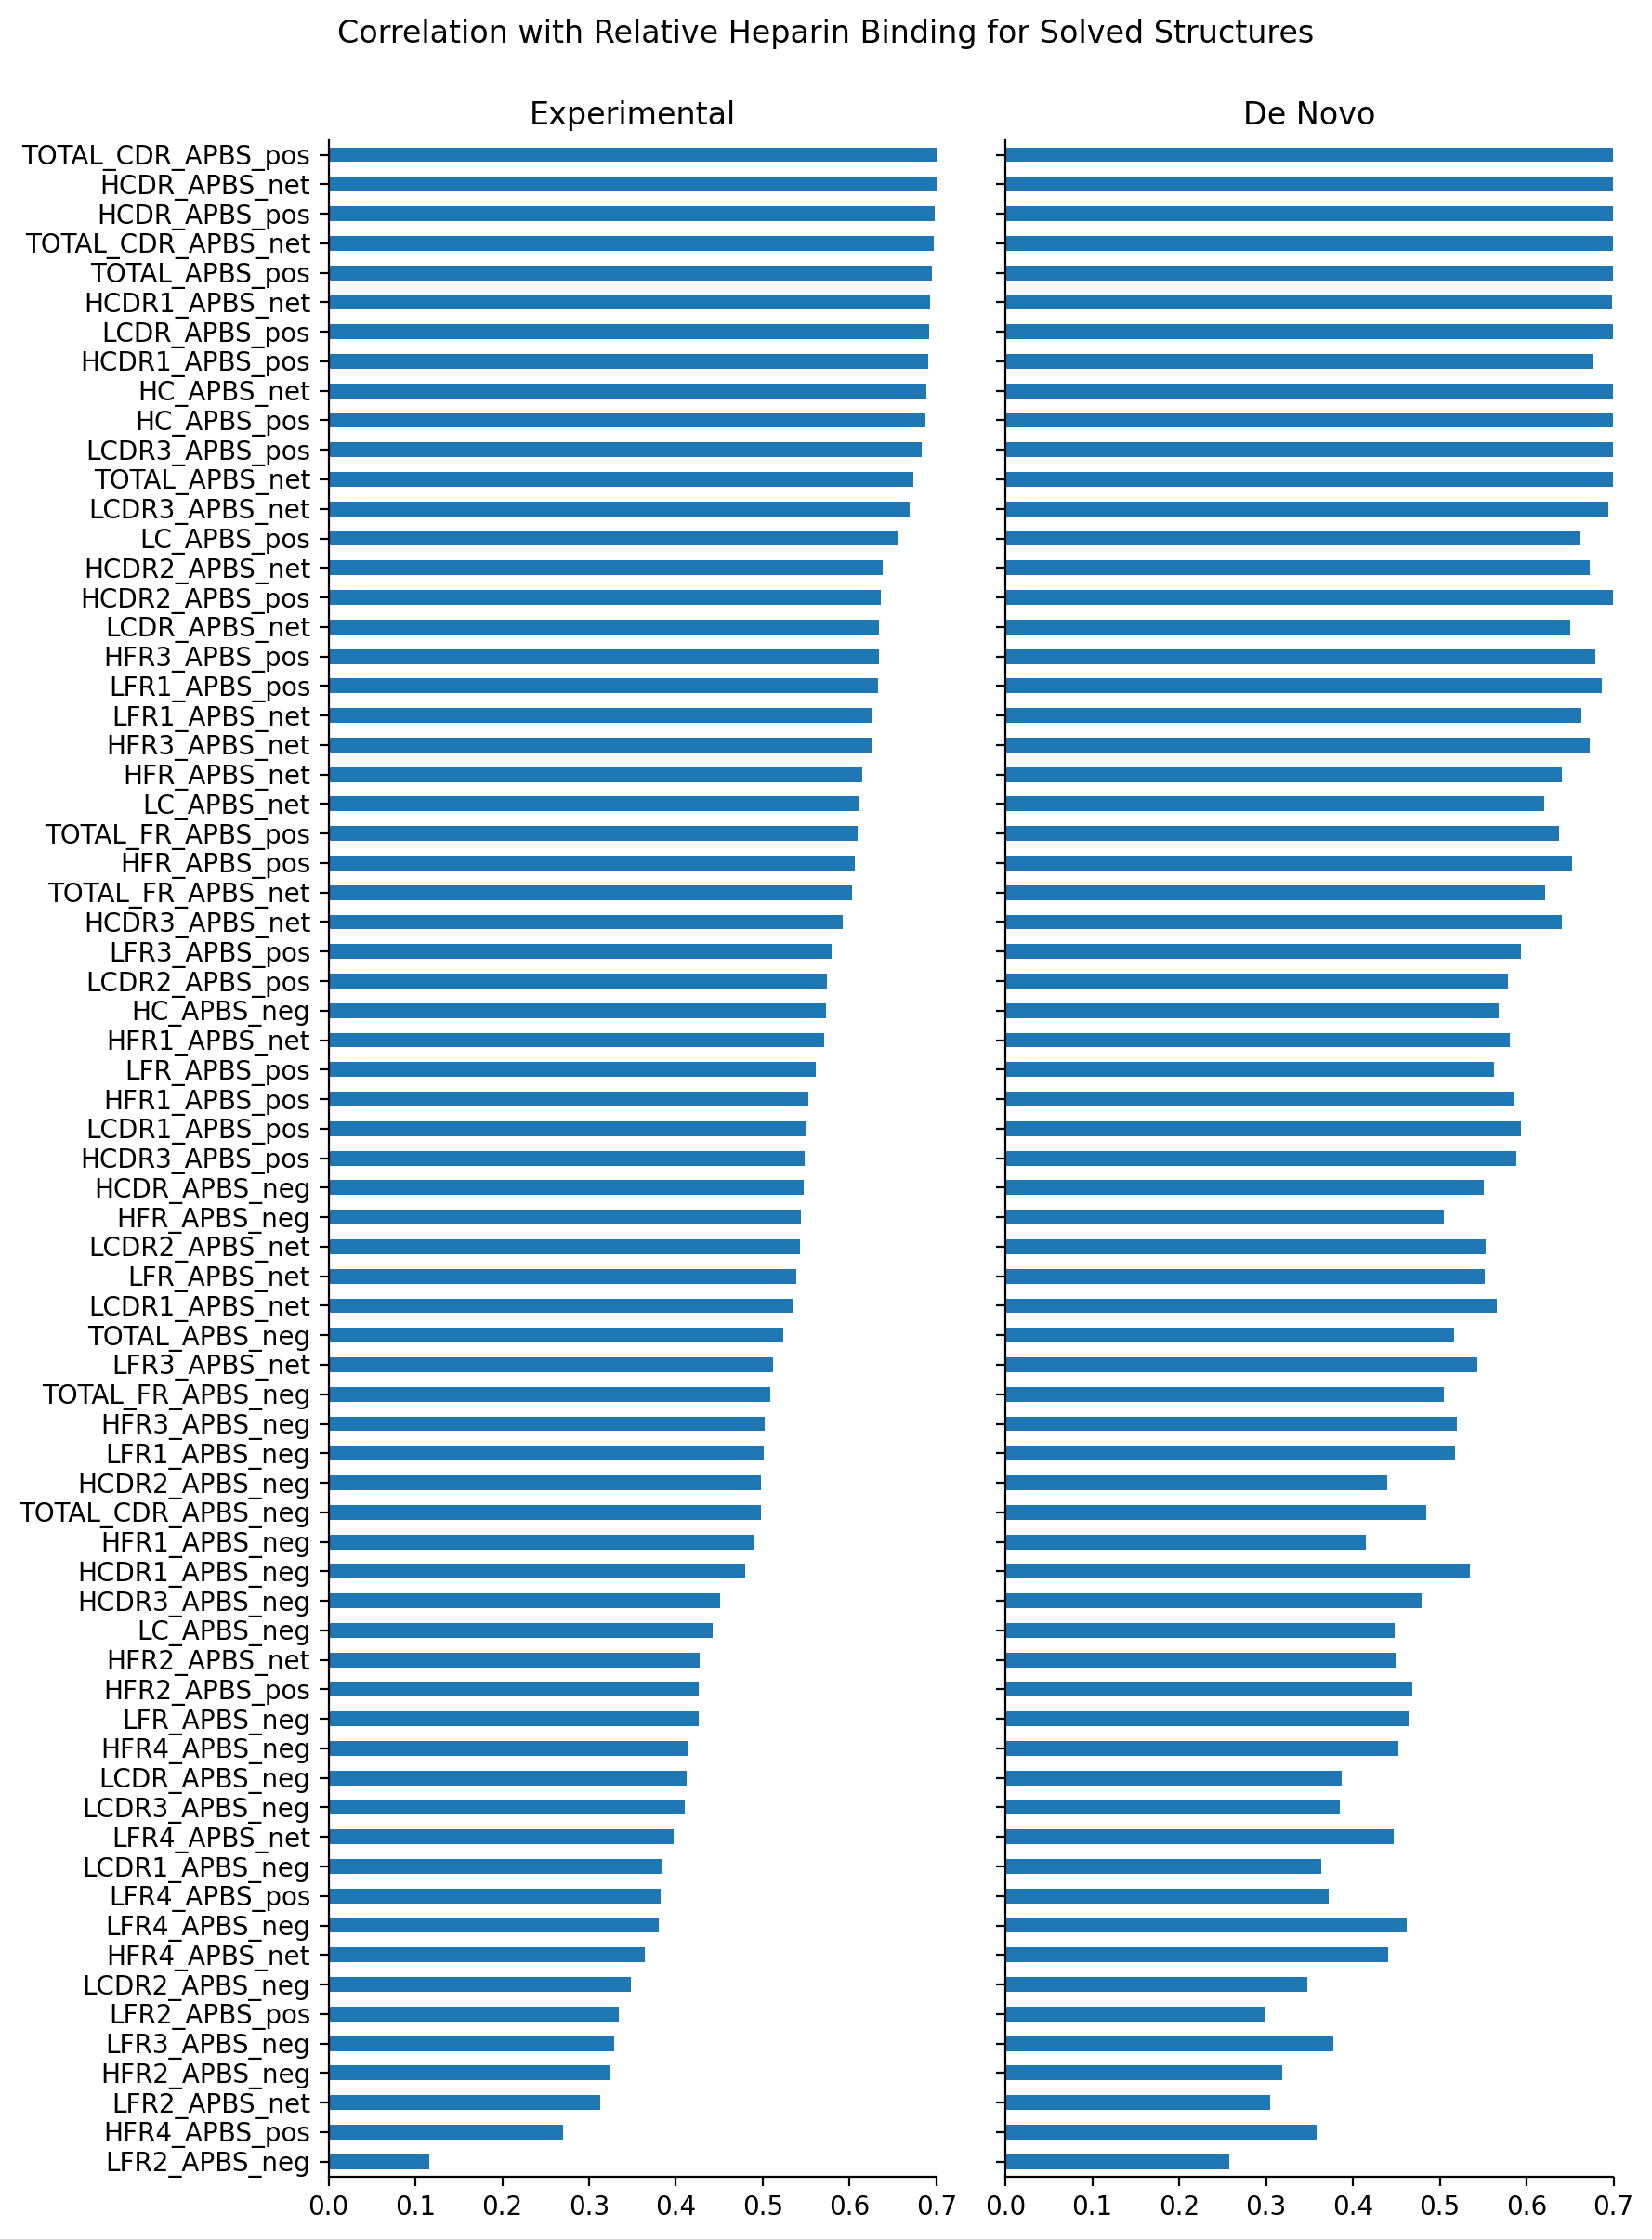

In [13]:
order = heparin_corr.index

fig, axes = plt.subplots(1,2, figsize =(9, 12))

ax =heparin_corr[order].plot(kind = 'barh', ax= axes[0])
ax.set(title = 'Experimental',xlim=(0,0.7))

ax = predicted_heparin_corr[order].plot(kind = 'barh', ax = axes[1])
ax.set(title = 'De Novo', yticklabels="", xlim=(0,0.7))
sns.despine()

fig.suptitle('Correlation with Relative Heparin Binding for Solved Structures',y=1 )
plt.tight_layout()

#### Plot the 9 descriptors that are most correlated with Heparin Binding
Below I am using the absolute correlation. 

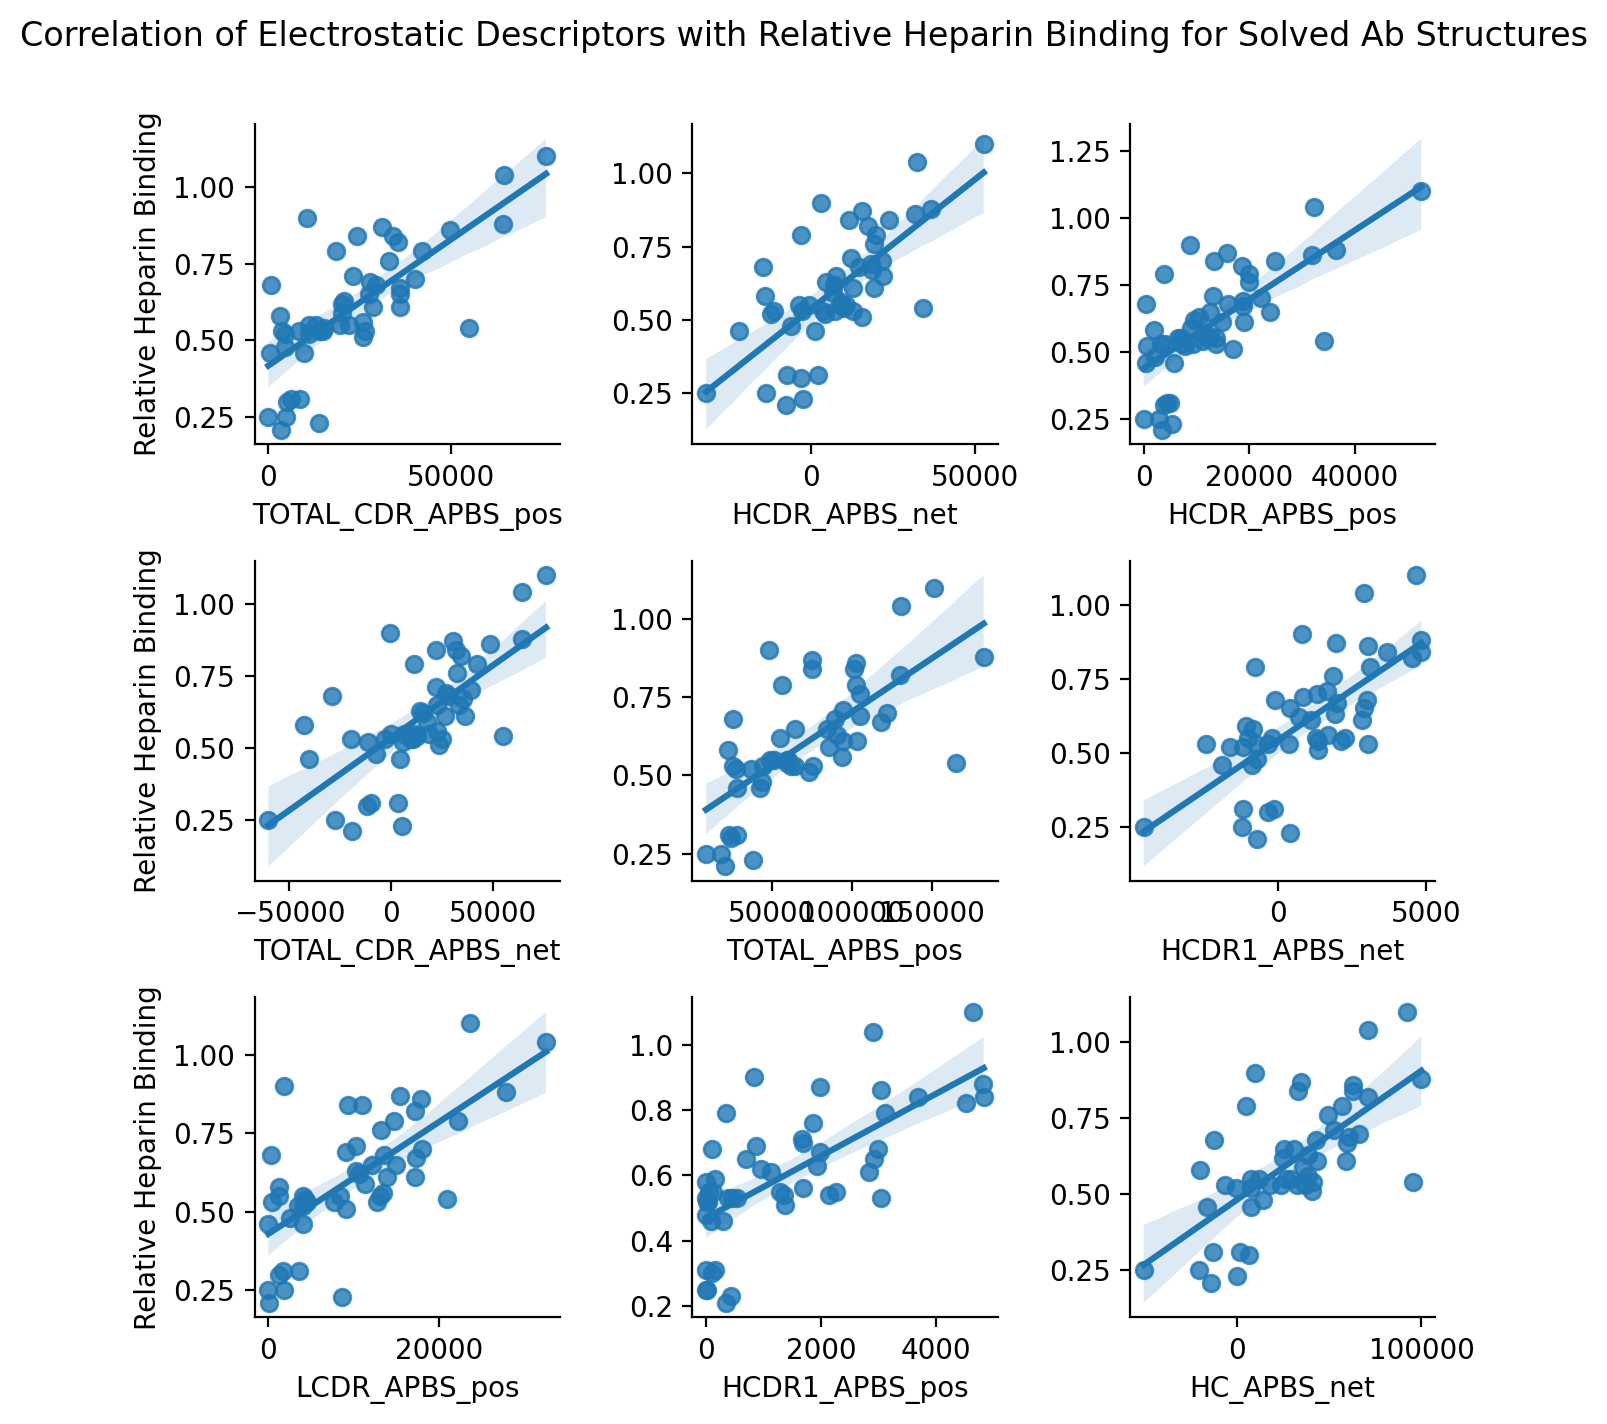

In [14]:
# plot the 9 most correlated in magnitude 
abs_heparin_corr = np.abs(heparin_corr).sort_values(ascending = False)

fig, axes = plt.subplots(3,3, figsize = (7,7))
axes = np.ravel(axes)
for i in range(9):
    col = abs_heparin_corr.index[i]
    sns.regplot(data = solved_descriptors_df, x=col, y= 'Heparin', ax = axes[i])
    axes[i].set(xlabel = col)
    if i%3==0: 
        axes[i].set(ylabel = 'Relative Heparin Binding')
    else:
        axes[i].set(ylabel='')
sns.despine()
fig.suptitle('Correlation of Electrostatic Descriptors with Relative Heparin Binding for Solved Ab Structures', y=1.01)
plt.tight_layout()


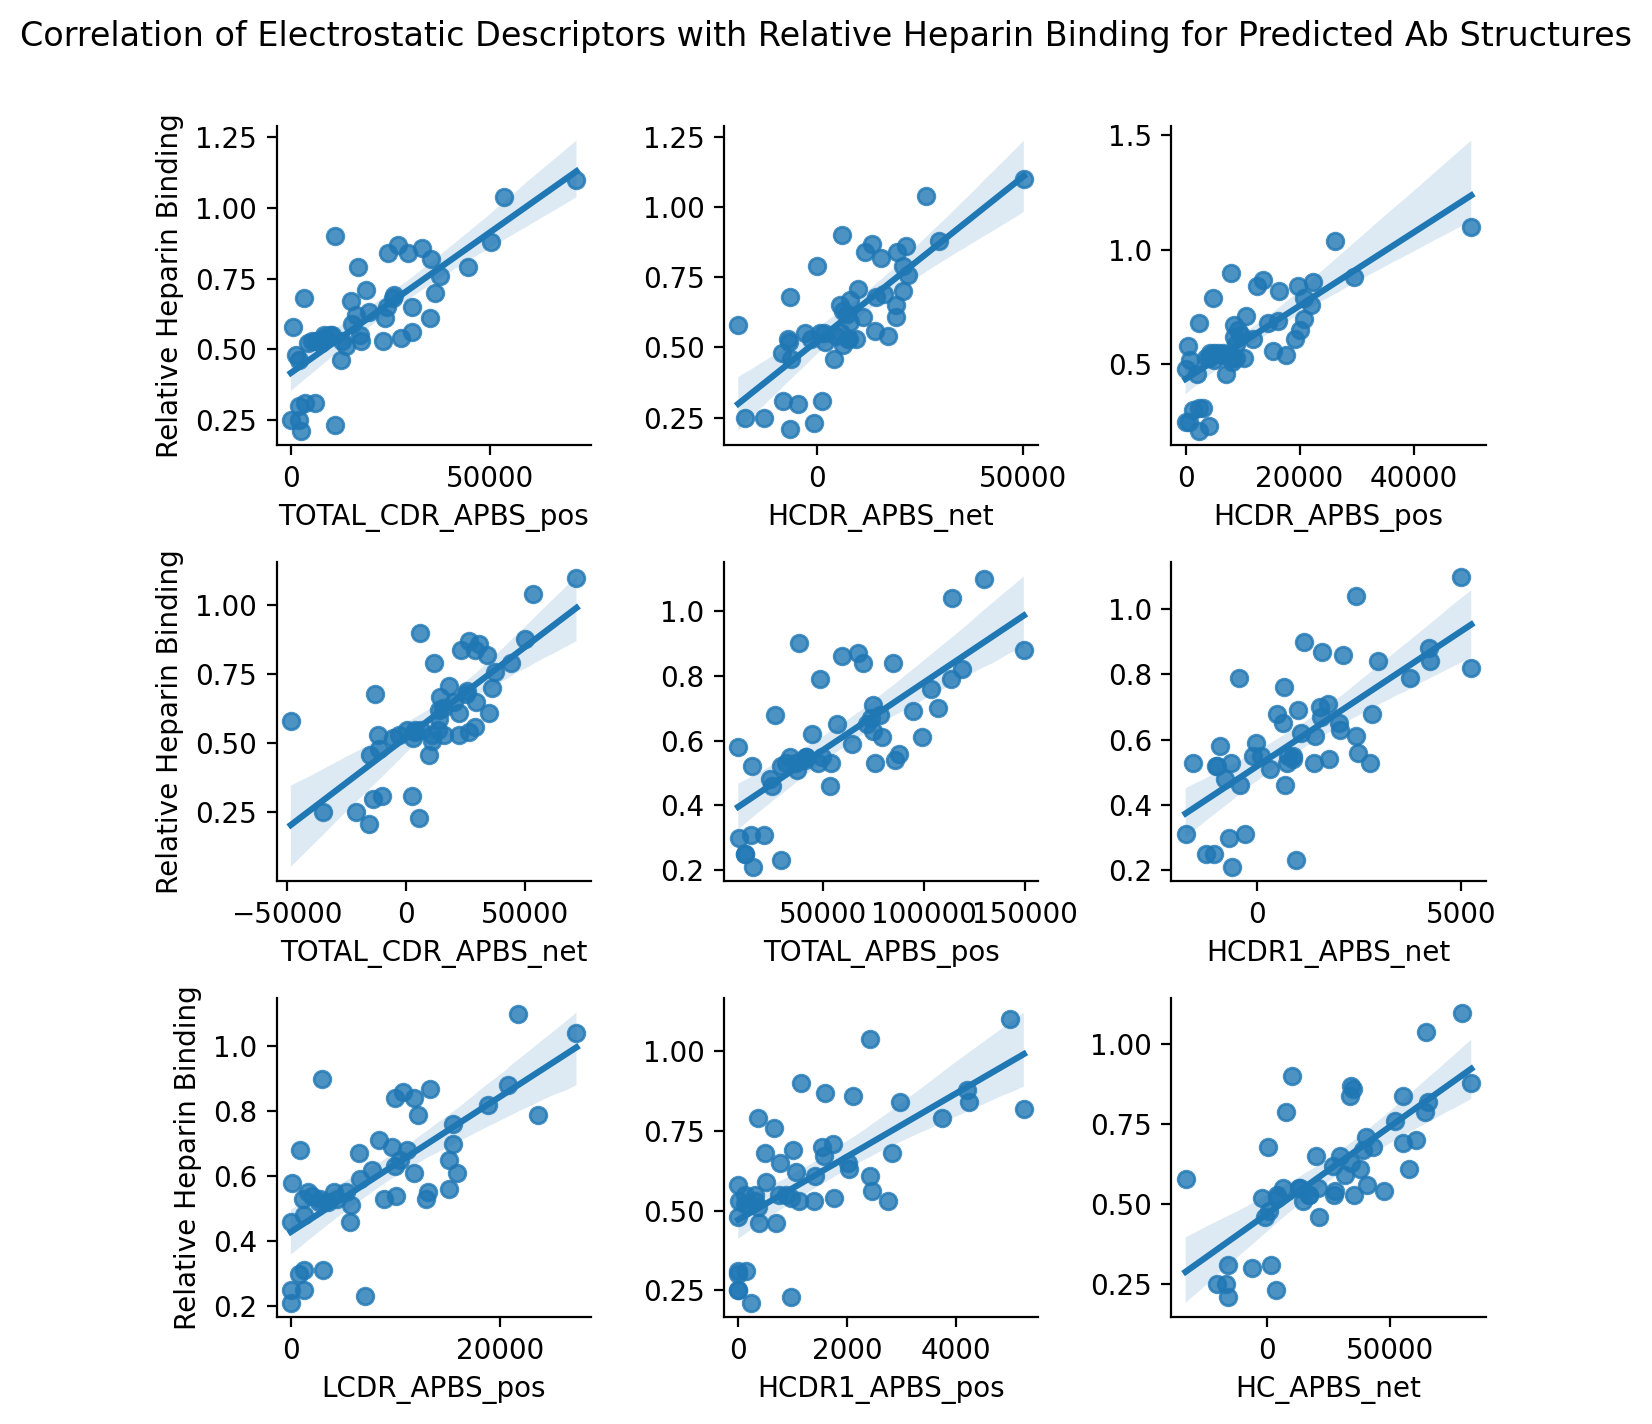

In [15]:
abs_heparin_corr = np.abs(heparin_corr).sort_values(ascending = False)

fig, axes = plt.subplots(3,3, figsize = (7,7))
axes = np.ravel(axes)
for i in range(9):
    col = abs_heparin_corr.index[i]
    sns.regplot(data = predicted_descriptors_df, x=col, y= 'Heparin', ax = axes[i])
    axes[i].set(xlabel = col)
    if i%3==0: 
        axes[i].set(ylabel = 'Relative Heparin Binding')
    else:
        axes[i].set(ylabel='')
sns.despine()
fig.suptitle('Correlation of Electrostatic Descriptors with Relative Heparin Binding for Predicted Ab Structures', y=1.01)
plt.tight_layout()

### Look at the correlograms

In [16]:
def plot_correlogram(d, cmap='RdBu', method = 'pearson', compute_correlation=False):

    # Compute the correlation matrix
    if compute_correlation:
        corr = d.corr()
    else:
        corr = d

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

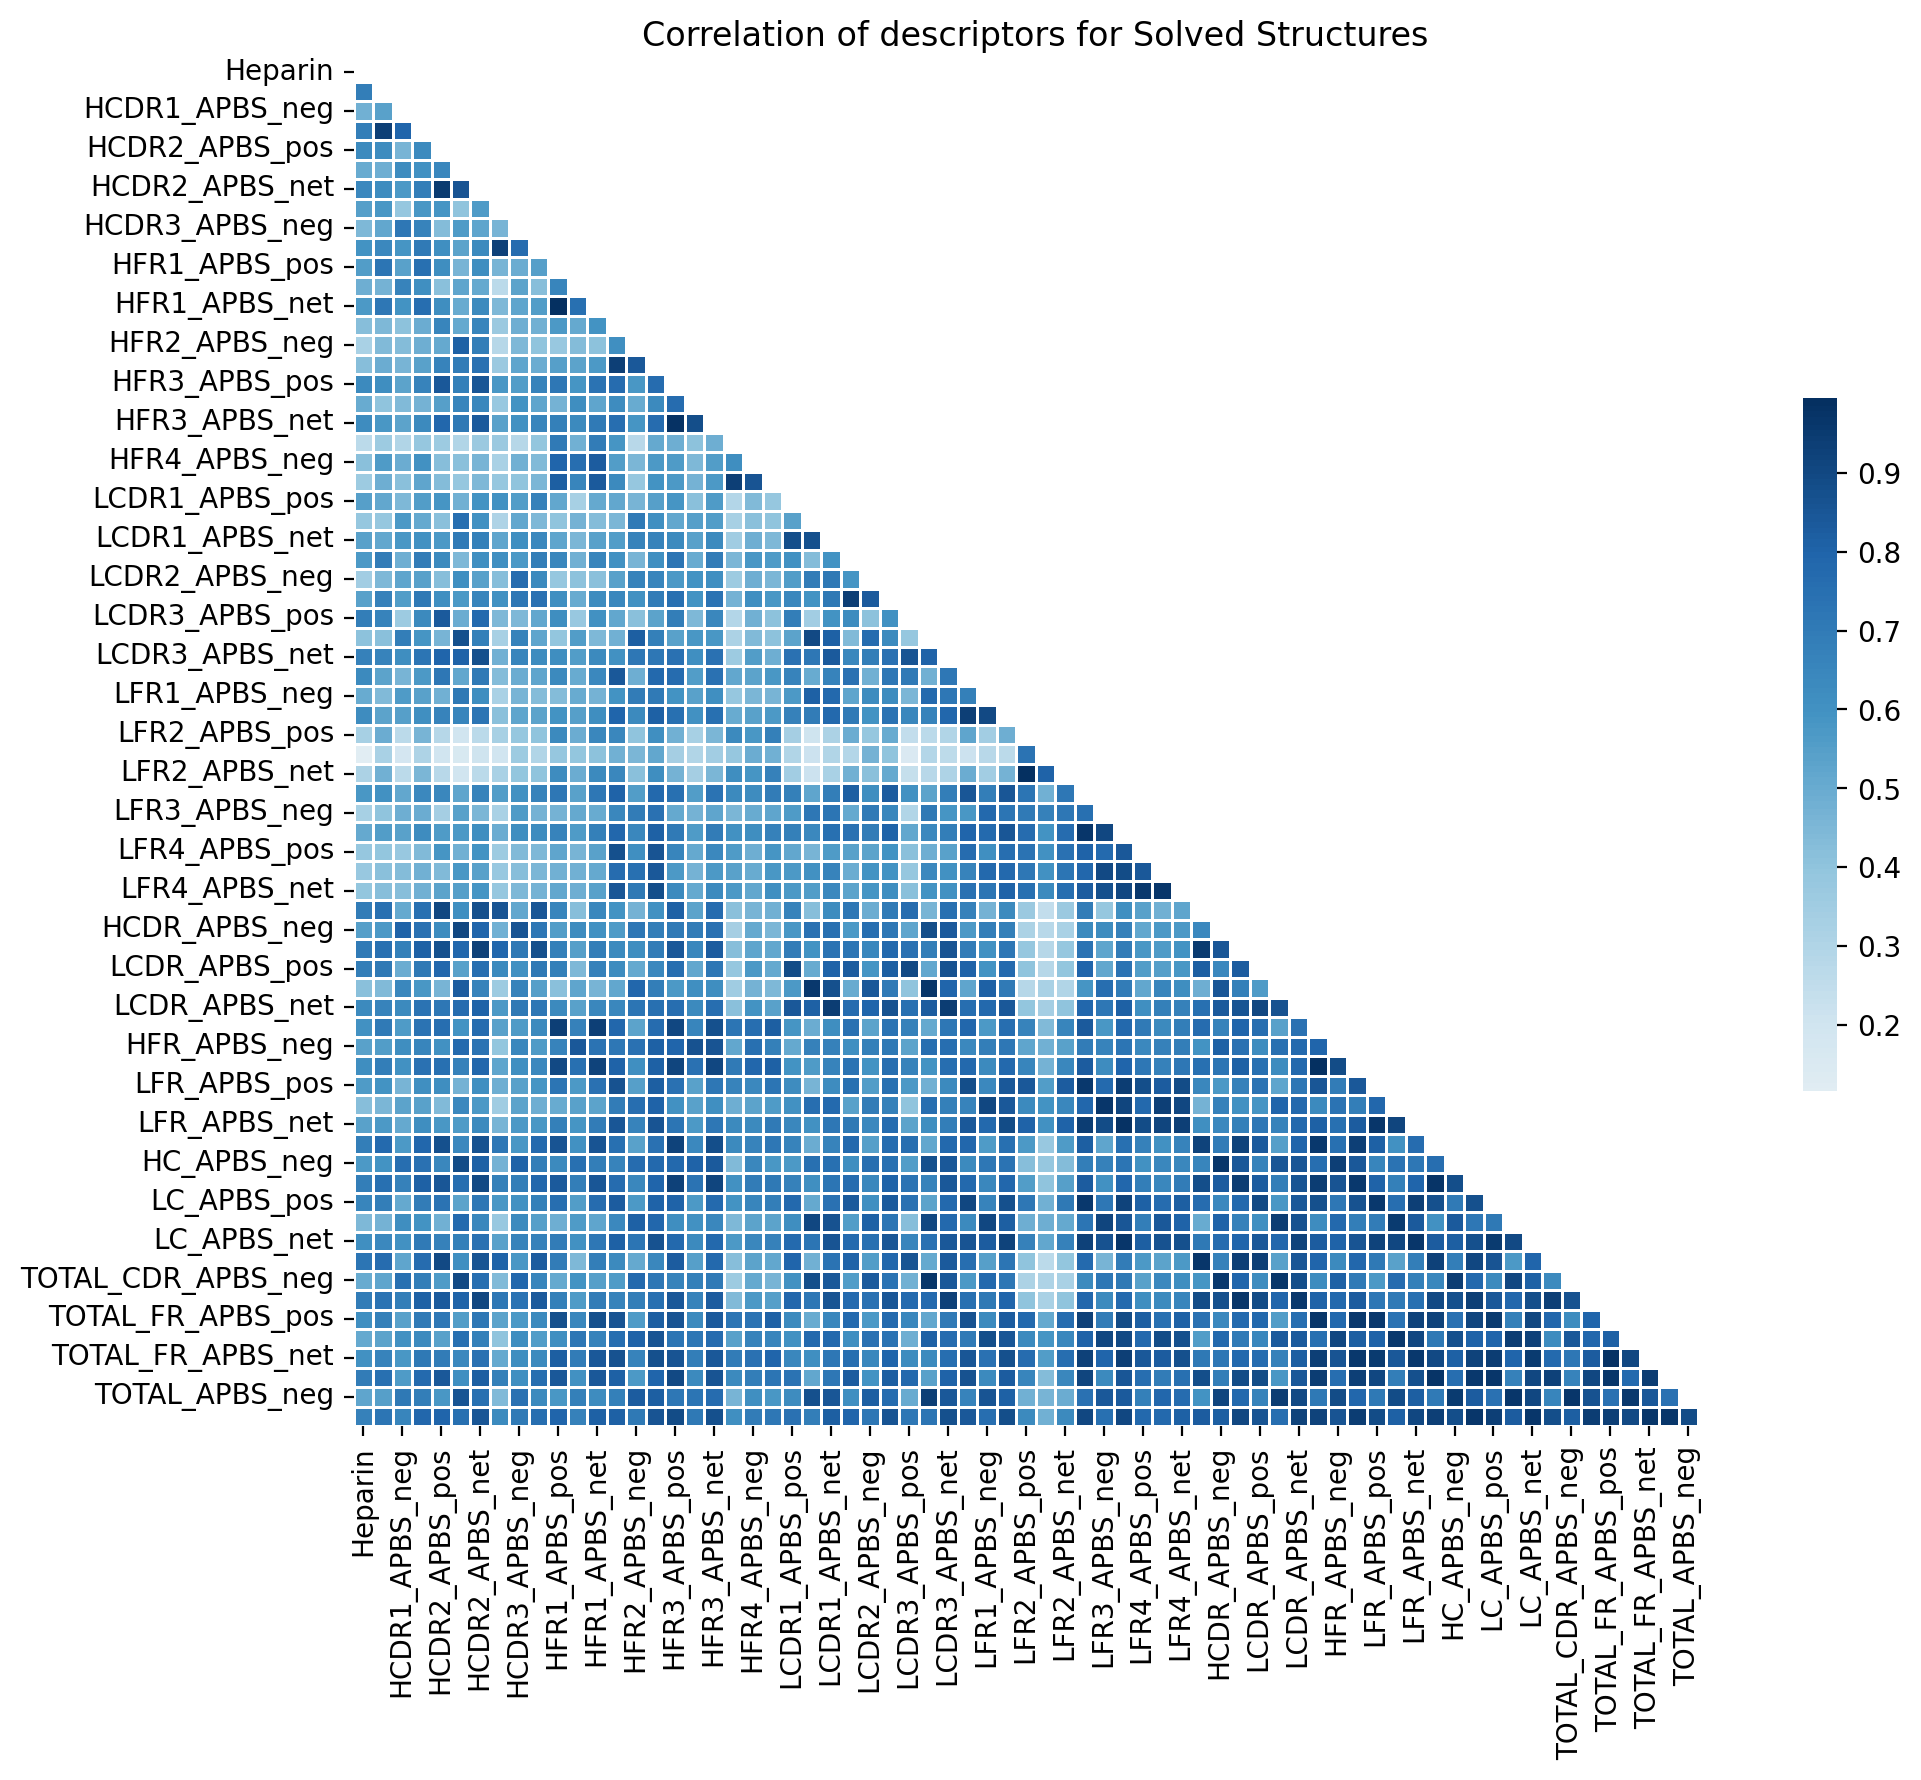

In [17]:
plot_correlogram(solved_corr)
plt.gca().set_title('Correlation of descriptors for Solved Structures');

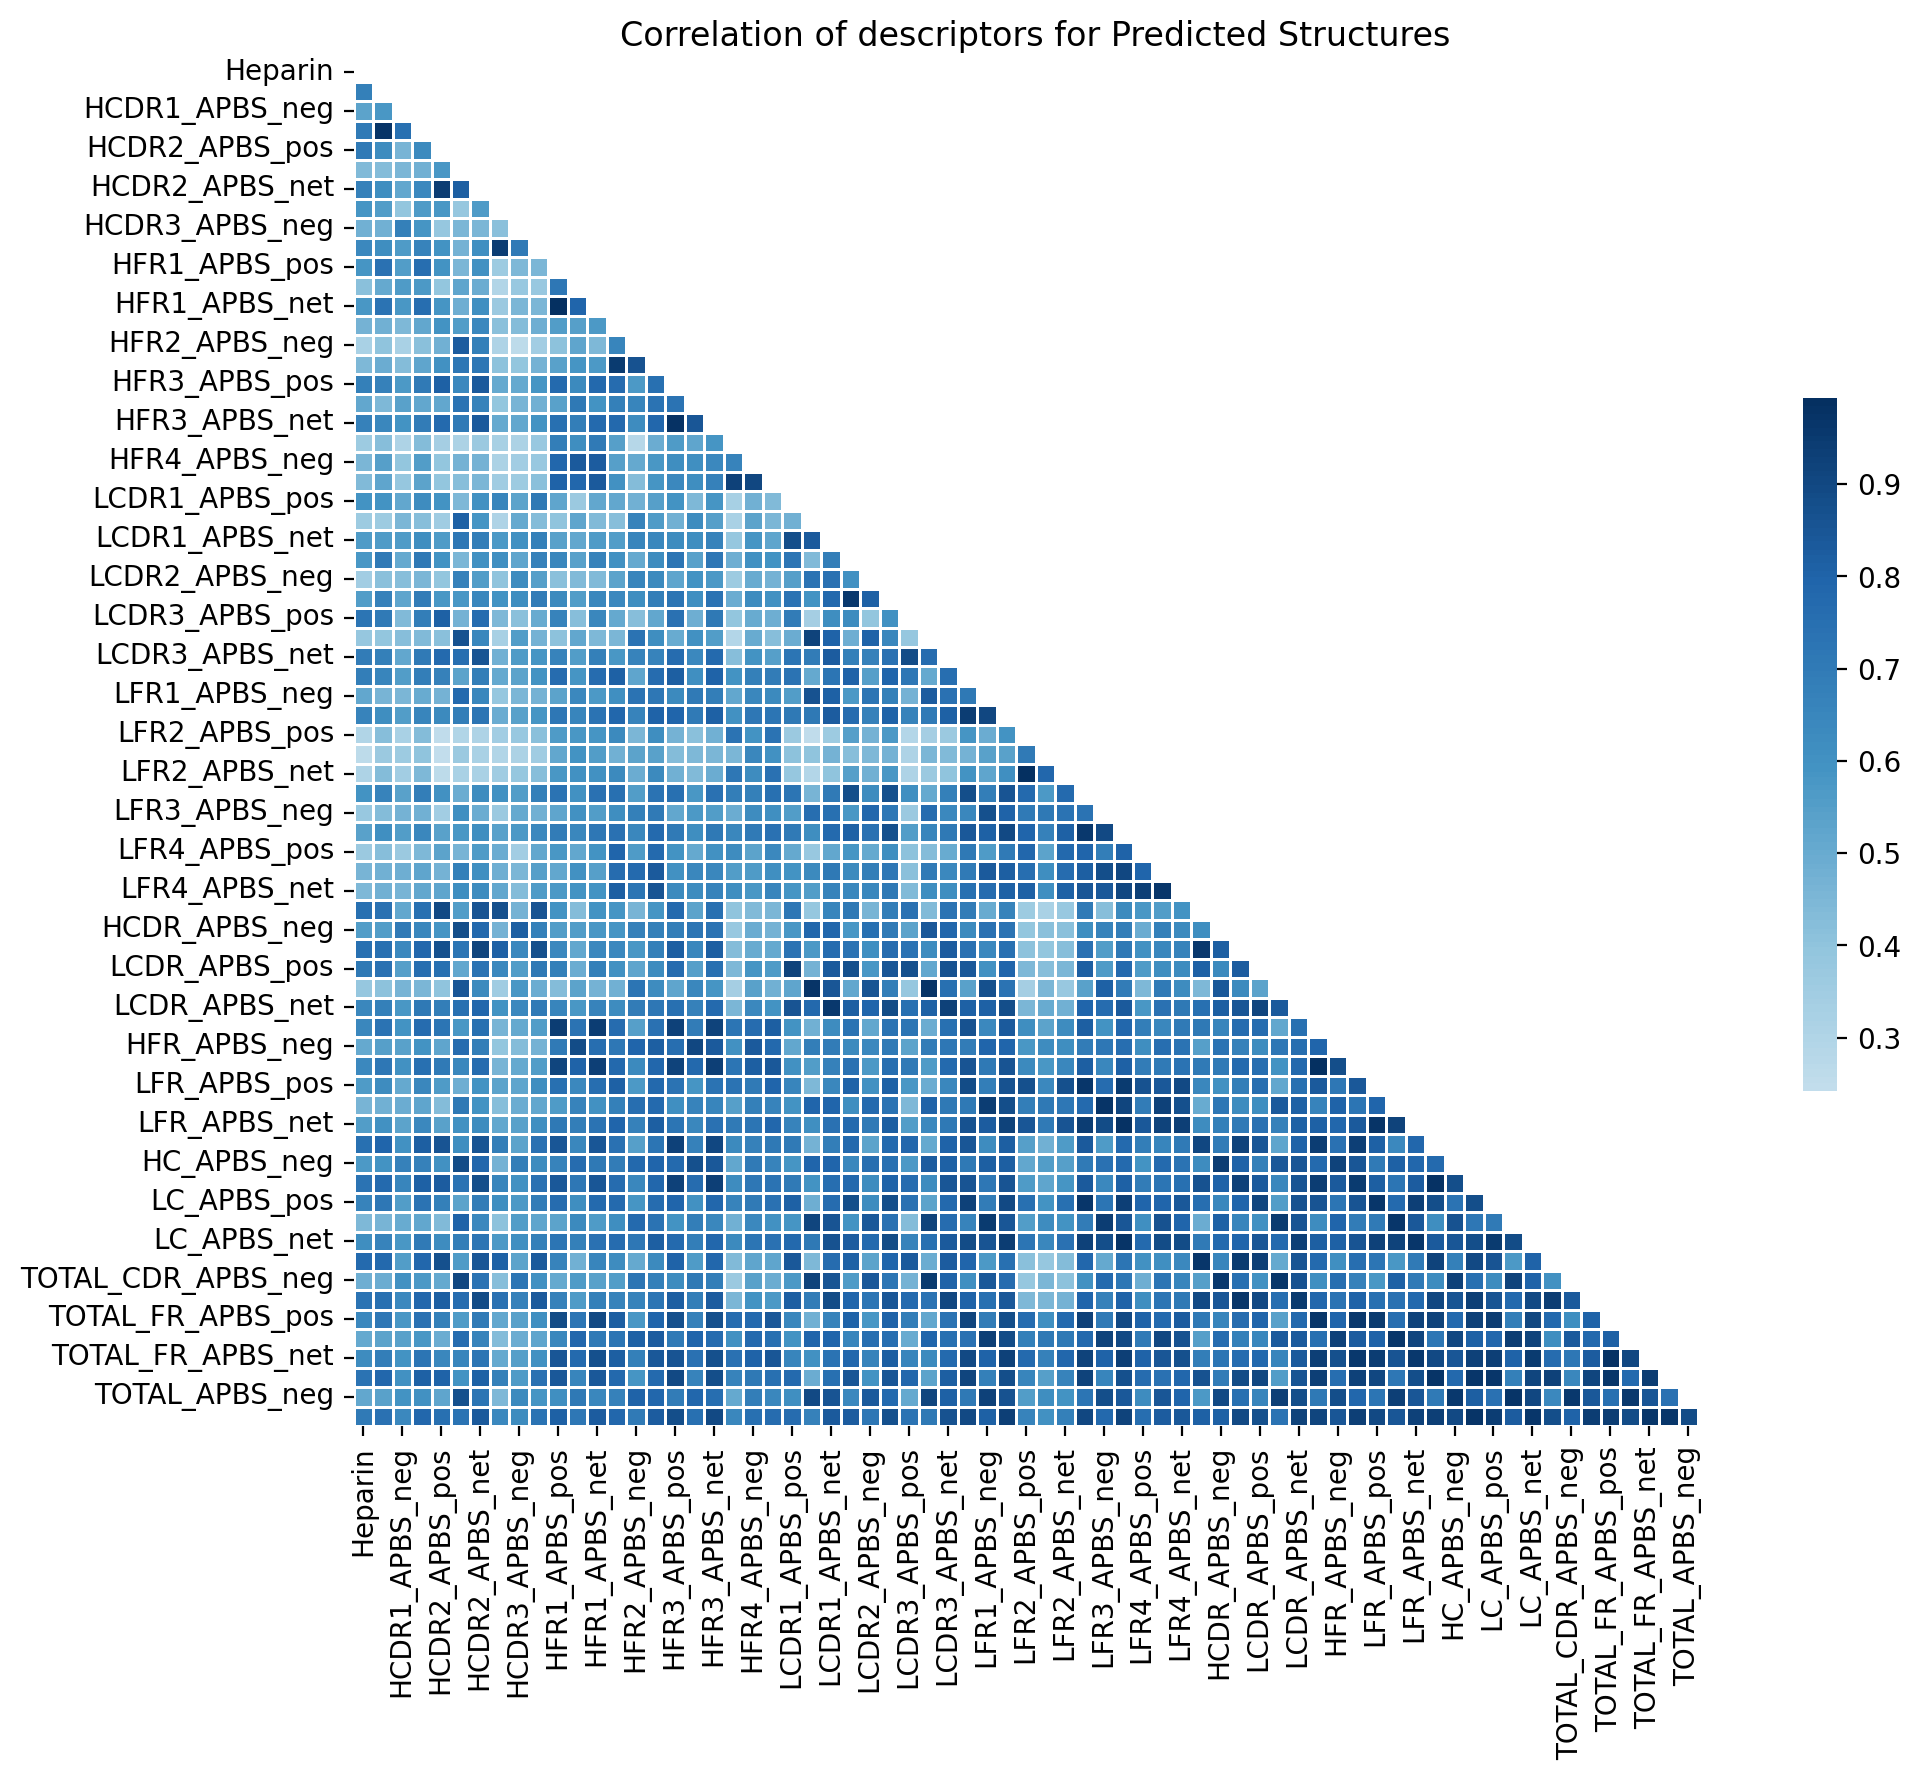

In [18]:
plot_correlogram(predicted_corr)
plt.gca().set_title('Correlation of descriptors for Predicted Structures');

#### Plot for the top features the predicted versus solved desciptors. 

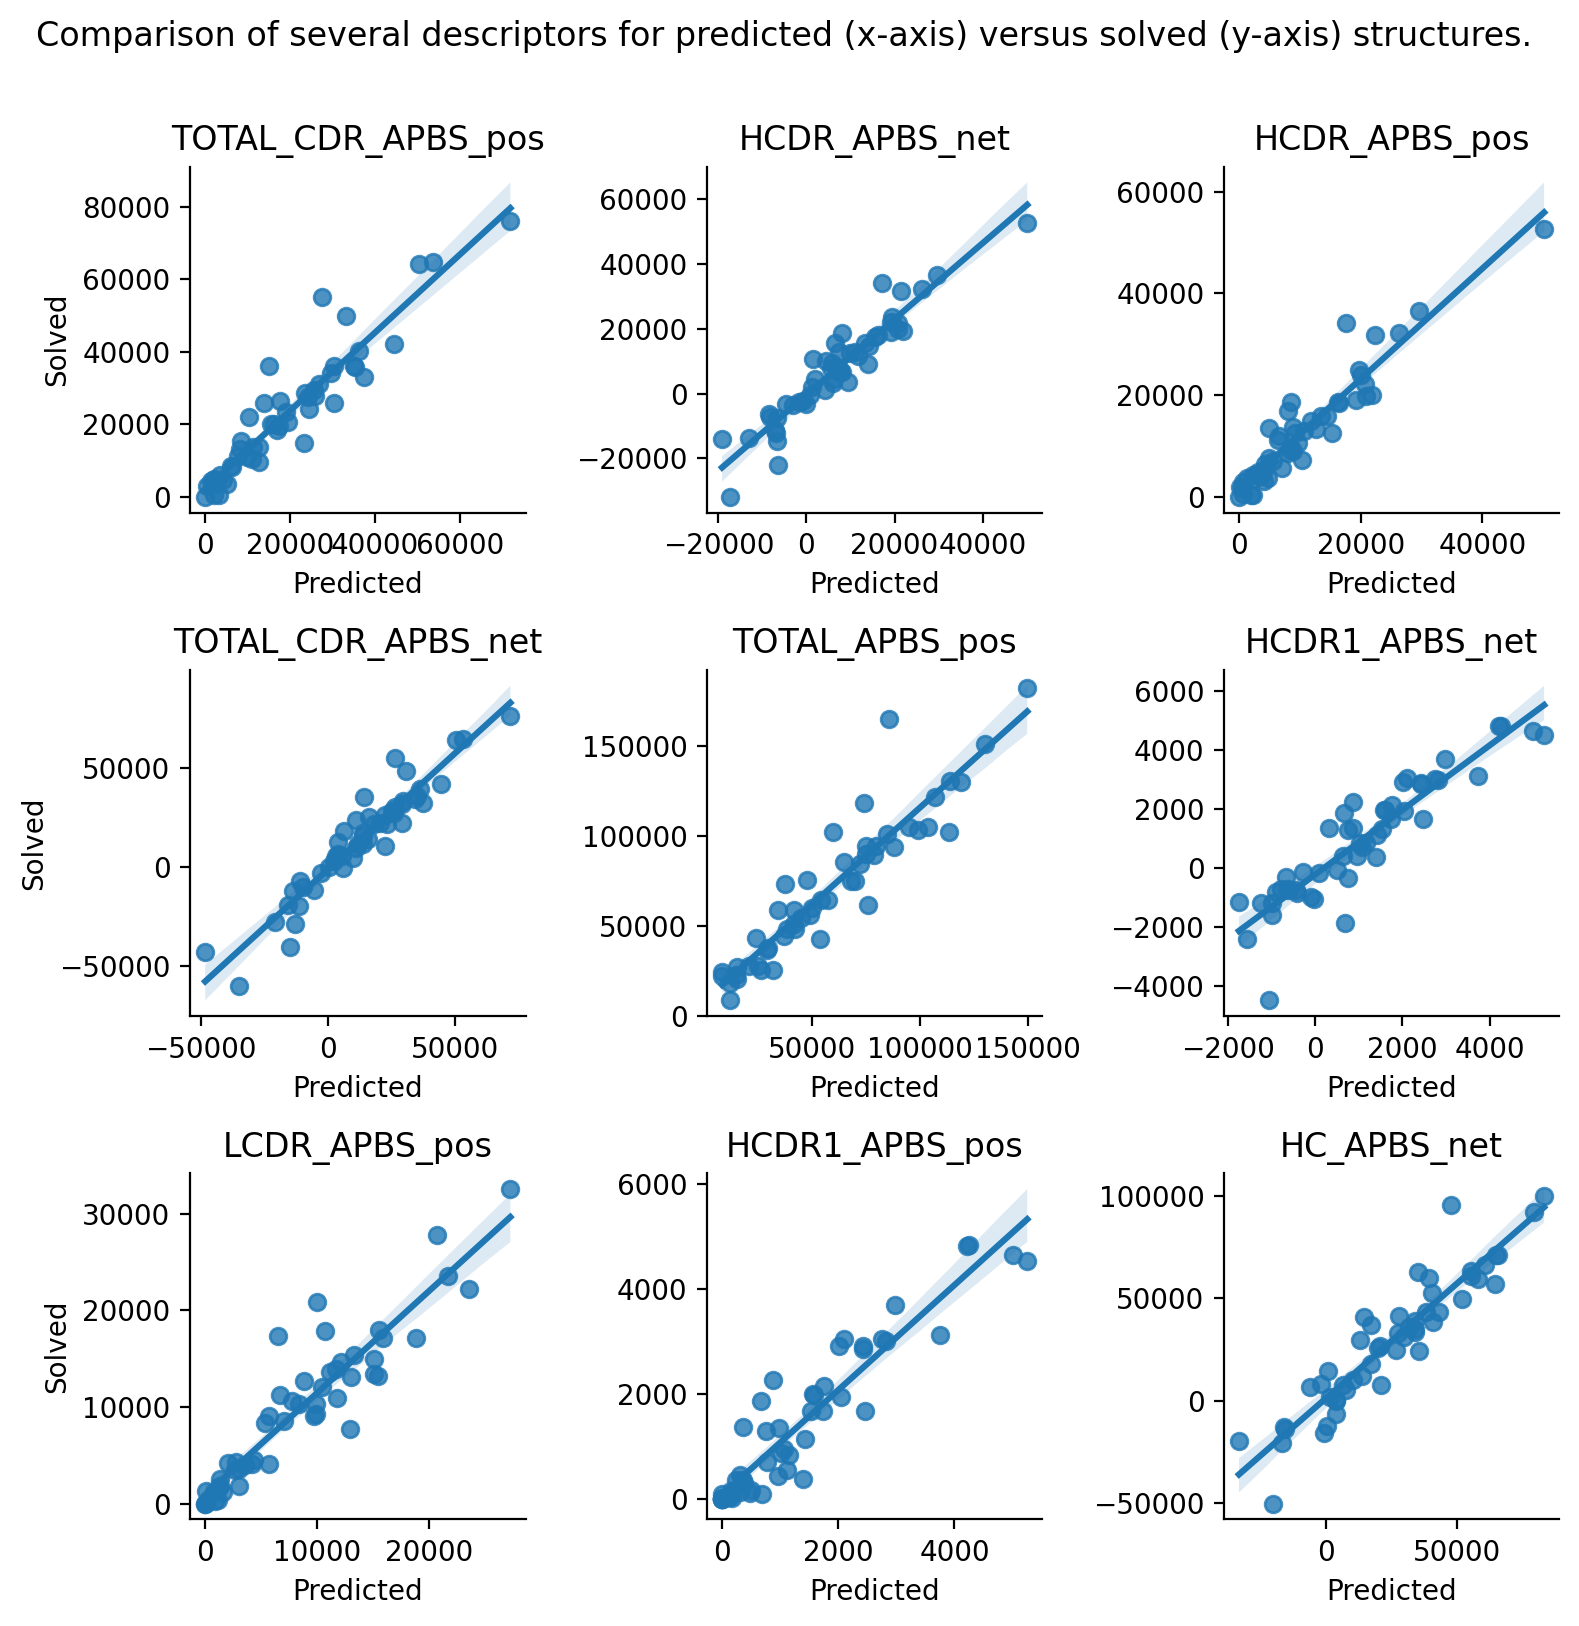

In [19]:
fig, axes = plt.subplots(3,3, figsize = (8,8))
axes = np.ravel(axes)
for i in range(9):
    col = abs_heparin_corr.index[i]
    ax = sns.regplot(x= predicted_descriptors_df[col], y=solved_descriptors_df[col], ax = axes[i])
    ax.set(xlabel = 'Predicted', title = col)
    if i%3==0:
        ax.set(ylabel='Solved')
    else:
        ax.set(ylabel="")

sns.despine()
fig.suptitle('Comparison of several descriptors for predicted (x-axis) versus solved (y-axis) structures. ', y=1.01)
plt.tight_layout()

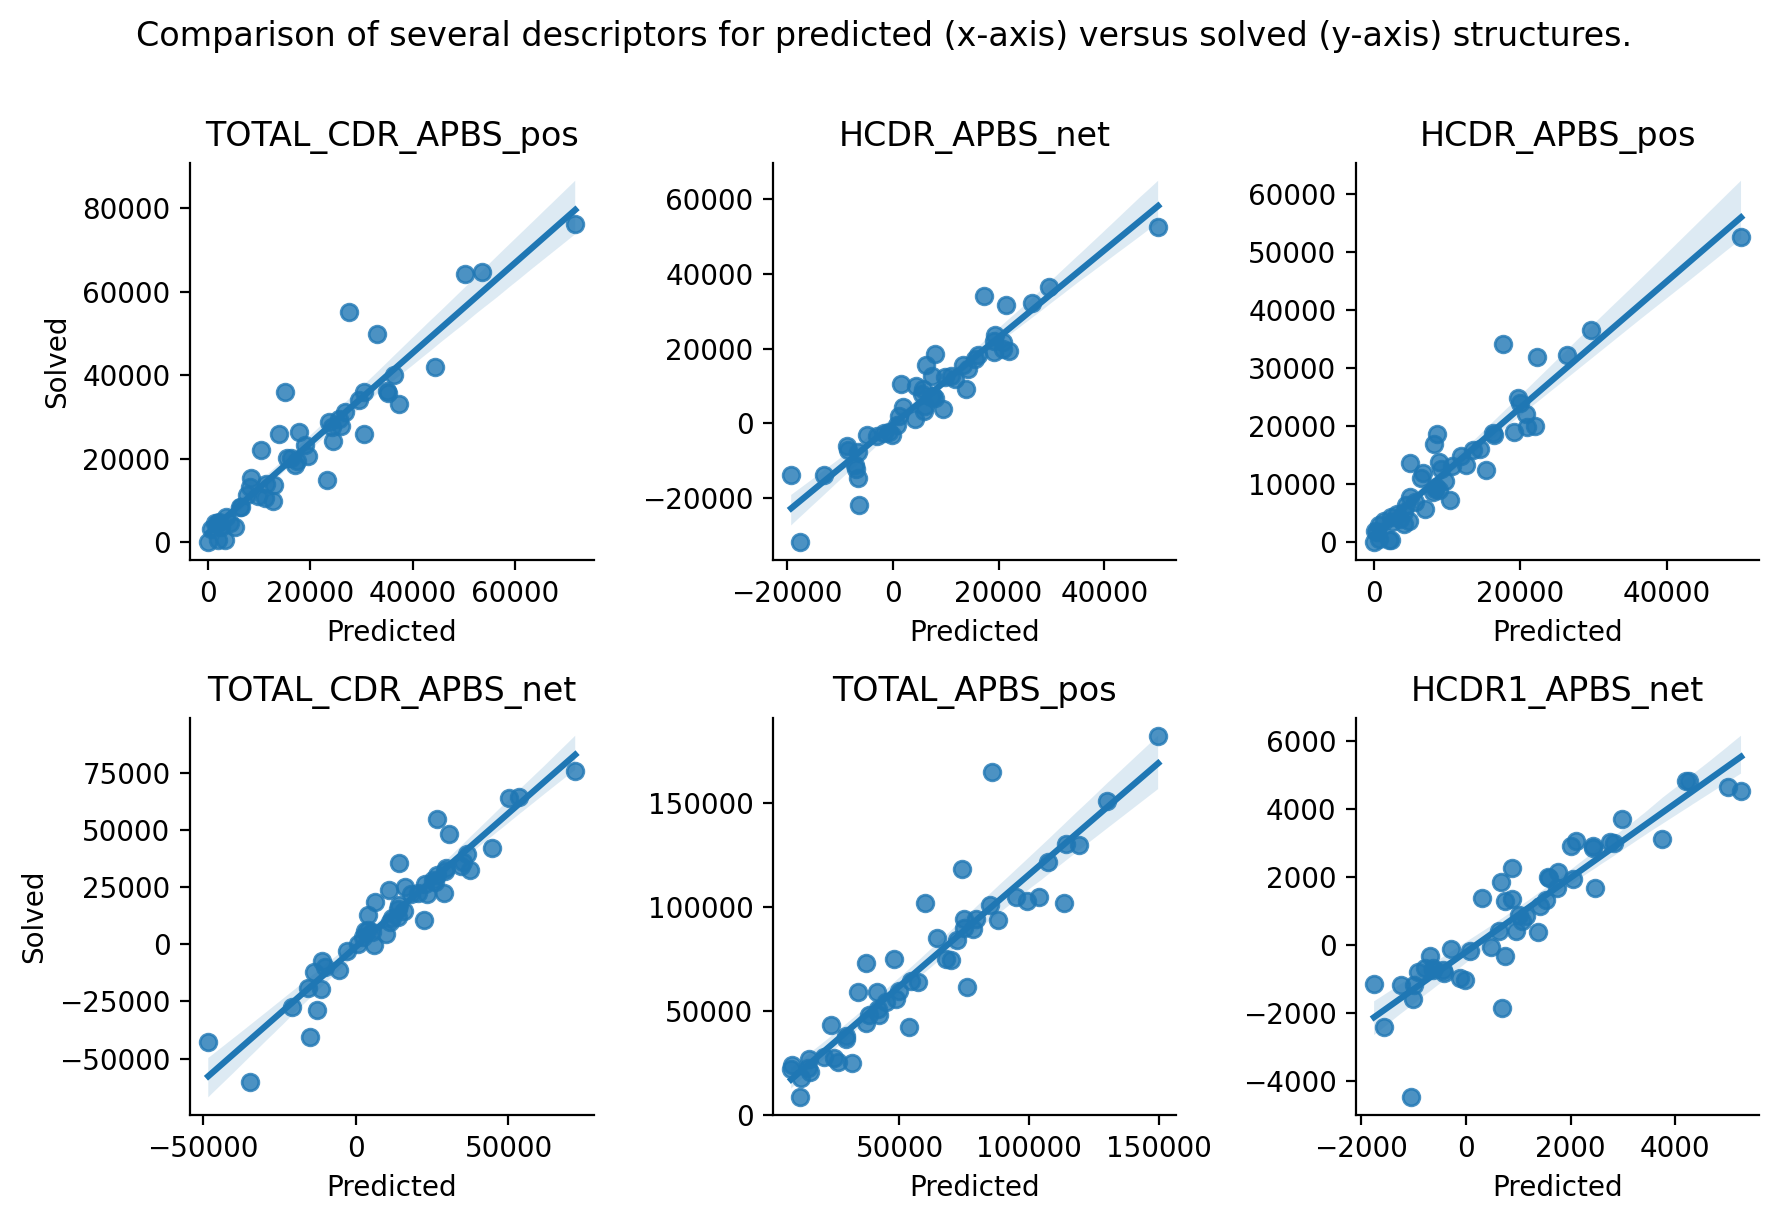

In [20]:
fig, axes = plt.subplots(2,3, figsize = (9,6))
axes = np.ravel(axes)
for i in range(6):
    col = abs_heparin_corr.index[i]
    ax = sns.regplot(x= predicted_descriptors_df[col], y=solved_descriptors_df[col], ax = axes[i])
    ax.set(xlabel = 'Predicted', title = col)
    if i%3==0:
        ax.set(ylabel='Solved')
    else:
        ax.set(ylabel="")

sns.despine()
fig.suptitle('Comparison of several descriptors for predicted (x-axis) versus solved (y-axis) structures. ', y=1.01)
plt.tight_layout()

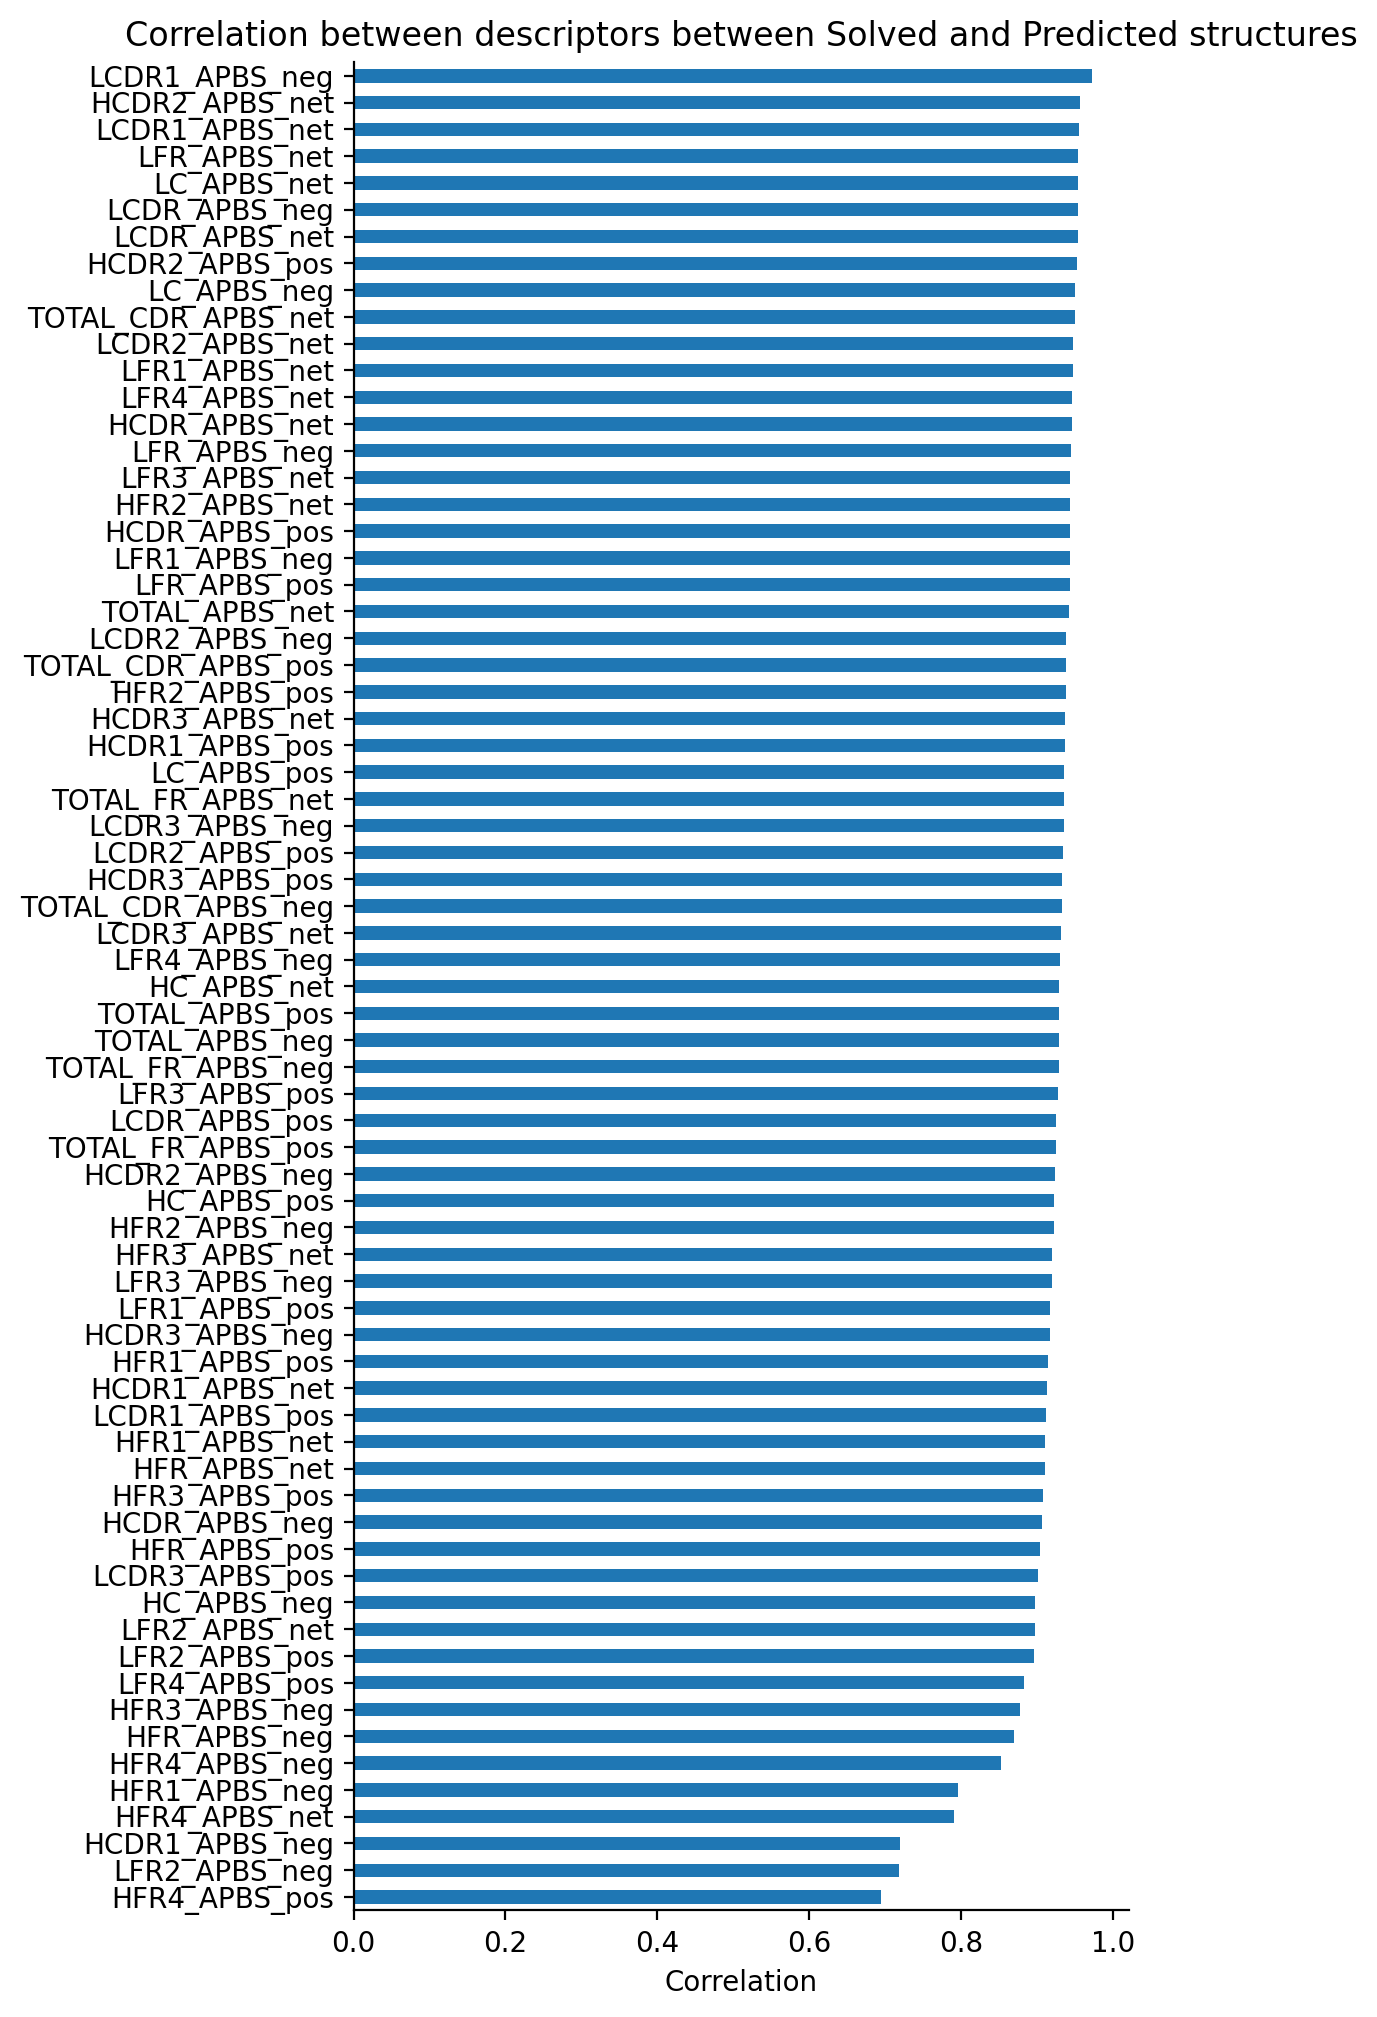

In [21]:
solved_predicted_corr = (predicted_descriptors_df[cols].corrwith(solved_descriptors_df[cols])
                         .sort_values()
                         .iloc[:-1]
                         )
ax = solved_predicted_corr.plot(kind = 'barh', figsize = (5, 12))
ax.set(xlabel='Correlation', title ='Correlation between descriptors between Solved and Predicted structures')
sns.despine()


In [22]:
print(f'The max correlation for heparin binding for solved structures is {round(heparin_corr.max(),2)}, and for de novo structures {round(predicted_heparin_corr.max(),2)}')
print(f'The average correlation for heparin binding for solved structures is {round(heparin_corr.mean(),2)}, and for de novo structures {round(predicted_heparin_corr.max(),2)}')

The max correlation for heparin binding for solved structures is 0.73, and for de novo structures 0.77
The average correlation for heparin binding for solved structures is 0.53, and for de novo structures 0.77


#### Compare sequences

In [23]:
predicted_pdbs = renumbered_ab_dir
antibodies =solved_descriptors_df.index

In [24]:
def show_struct(pdb_file, size = 500, gui = False): 
    print(pdb_file.name)
    view = nv.show_structure_file(str(pdb_file))
    view._remote_call('setSize', target='Widget', args=['',f'{size}px'])
    view.render_image(factor = 2)
    view.display(gui)
    return view

def get_ab_file(ab): 
    return ([f for f in ls(fv_path) if f.name.startswith(ab) and f.name.endswith('.pdb')][0], 
            [f for f in ls(predicted_pdbs) if f.name.startswith(ab) and f.name.endswith('.pdb') ][0]
            )


def extract_heavy_light_chain_fv_from_pdb(pdb_file, scheme='kabat'): 
    """extract the heavy and light chain. 

    Args:
        pdb_file (str|path):
        scheme (str, optional ):  
    Returns: 
        dict: 
    """
    seqs  = extract_sequence_from_pdb(pdb_file)
    fvs = {}
    for  seq in seqs.values(): 
        chain = AbChain(seq, scheme = 'kabat')
        if chain.is_heavy_chain(): 
            name = 'H'
        if chain.is_light_chain():
            name = 'L'
        fvs[name] = chain.seq

    return fvs


def pairwise_compare_antibodies_fv(seqs1, seqs2): 
    """_summary_

    Args:
        seqs1 (dict): _description_
        seqs2 (dict): _description_
    """
    
    # Heavy chain
    aligner = PairwiseAligner()
    h_score = aligner.score(seqs1['H'], seqs2['H'])
    h_score/=min(len(seqs1['H']), len(seqs2['H']))

    # light chain score
    l_score = aligner.score(seqs1['L'], seqs2['L'])
    l_score/=min(len(seqs1['L']), len(seqs2['L']))

    return [h_score, l_score]



In [25]:
alignment_scores = []

for ab in antibodies: 
    solved, predicted = get_ab_file(ab)
    solved_fvs= extract_heavy_light_chain_fv_from_pdb(solved)
    predicted_fvs =extract_heavy_light_chain_fv_from_pdb(predicted)

    scores = pairwise_compare_antibodies_fv(solved_fvs, predicted_fvs)
    name = predicted.name.split('.')[0]
    alignment_scores.append([name] + scores )
scores_df = pd.DataFrame.from_records(alignment_scores, columns = ['antibody', 'Hscore', 'Lscore'])

In [26]:
scores_df['correlation'] = solved_descriptors_df[cols].T.corrwith(predicted_descriptors_df[cols].T)
scores_df['correlation'] = solved_descriptors_df[cols].T.corrwith(predicted_descriptors_df[cols].T).values
average_score = scores_df[['Hscore','Lscore']].mean(axis = 1)
scores_df.insert(0, 'average_score', average_score)


##### Plot a heatmap showing the alignment scores for heavy, light chain, average alignment score and correlation for each antibody. 
We are comparing the Predicted verus Solved sequences/structures.

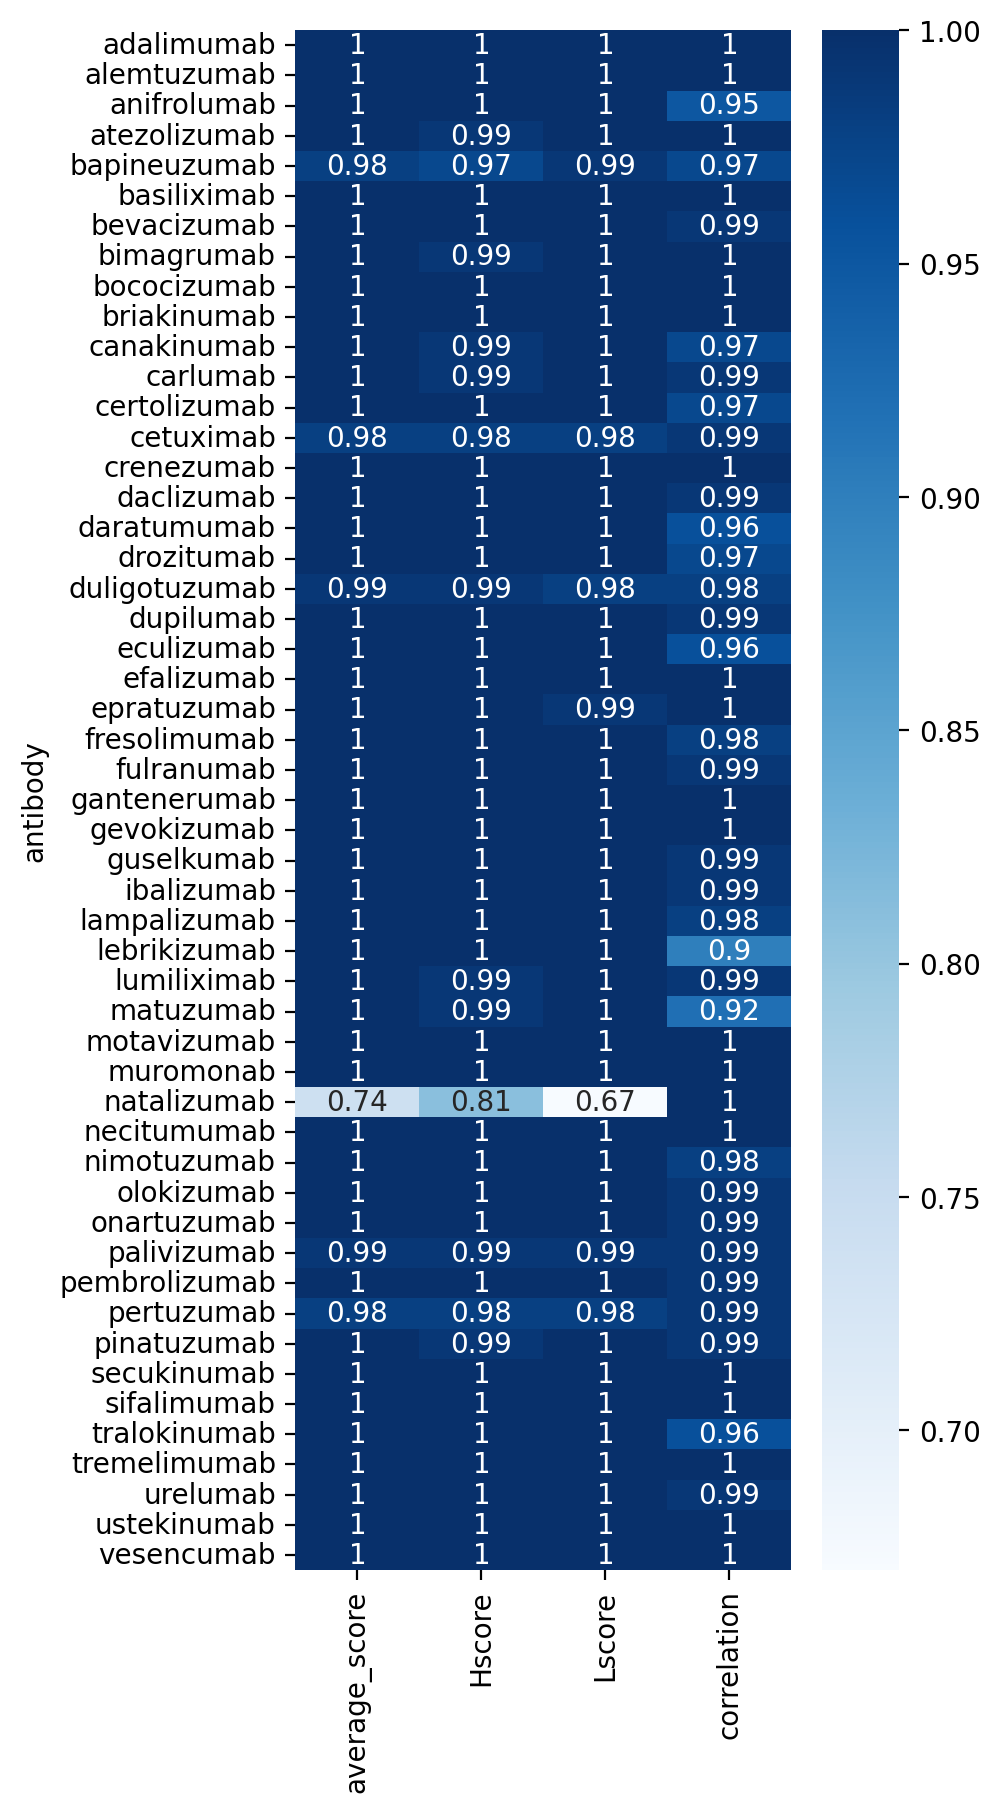

In [27]:
fig, axes = plt.subplots(1,1, figsize = (4, 10))
sns.heatmap(np.round(scores_df.set_index('antibody'), 2), annot=True, cmap ='Blues', ax=axes);

#### Try aligning structures. 

In [28]:
idx = 15
antibodies = antibodies.sort_values()

def align_antibodies(ab1, ab2, output_path=None, end_id=220):
  """Align antibodies structure and save.

    Args:
        ab1 (str|Path): path to first antibody. This is the template. 
        ab2 (str|Path): path to second antibody. This is aligned to the template. 
        output_path (str|Path, optional): _description_. Defaults to None.
        end_id (int, optional): position to align to. Defaults to 220. 
    Returns: 
      float: RMS
    """

  parser = PDBParser()
  ab1_structure = parser.get_structure('ab1', ab1)
  ab2_structure = parser.get_structure('ab2', ab2)

  ab_name = ab1.name.replace('.pdb','').split('_')[0]

  start_id = 1
  atoms_to_be_aligned = range(start_id, end_id + 1)

  ab1_model  = ab1_structure[0]
  ab2_model = ab2_structure[0]

  # Make a list of the atoms (in the structures) you wish to align.
  # In this case we use CA atoms whose index is in the specified range
  ab1_atoms = []
  ab2_atoms = []

  # Iterate of all chains in the model in order to find all residues
  for ab1_chain in ab1_model:
    # Iterate of all residues in each model in order to find proper atoms
    for ab1_res in ab1_chain:
      # Check if residue number ( .get_id() ) is in the list
      if ab1_res.get_id()[1] in atoms_to_be_aligned:
        # Append CA atom to list
        ab1_atoms.append(ab1_res['CA'])

  # Do the same for the pred structure
  for ab2_chain in ab2_model:
    for ab2_res in ab2_chain:
      if ab2_res.get_id()[1] in atoms_to_be_aligned:
        ab2_atoms.append(ab2_res['CA'])

  # Now we initiate the superimposer:
  super_imposer =Superimposer()
  super_imposer.set_atoms(ab1_atoms, ab2_atoms)
  super_imposer.apply(ab2_model.get_atoms())

  #RMS
  io = PDBIO()
  io.set_structure(ab2_structure) 
  if not output_path: 
    output_path = Path(ab1).parent

  aligned = output_path/f"{ab_name}_aligned.pdb"
  io.save(str(aligned))

  return super_imposer.rms

In [29]:


output_path = data_path/'aligned_antibodies'
if not output_path.exists():
    output_path.mkdir()

rms=[]
worked =[]
for ab in antibodies:
    try: 
        sol, pred = get_ab_file(ab)
        rms.append(align_antibodies(sol,pred, output_path, end_id=200))
        worked.append(ab)
    except:
        pass

rms_df = pd.DataFrame({'RMS':rms}, index =worked)

In [30]:
np.round(rms_df,2)

RMS
adalimumab     0.49
alemtuzumab    0.65
anifrolumab    0.39
atezolizumab   0.56
bevacizumab    0.80
briakinumab    0.33
canakinumab    0.44
certolizumab   0.93
cetuximab      0.41
crenezumab     0.66
daclizumab     0.53
daratumumab    0.64
drozitumab     0.95
duligotuzumab  1.00
dupilumab      0.42
eculizumab     1.30
efalizumab     0.77
fresolimumab   0.78
fulranumab     0.70
gevokizumab    0.33
guselkumab     1.03
ibalizumab     0.39
lampalizumab   0.34
lebrikizumab   0.41
lumiliximab    0.48
matuzumab      0.68
motavizumab    0.39
muromonab      0.57
necitumumab    0.35
olokizumab     0.41
onartuzumab    0.49
pertuzumab     0.56
secukinumab    0.35
sifalimumab    0.38
tremelimumab   0.32
urelumab       0.44
ustekinumab    0.49
vesencumab     1.01

In [31]:
idx =0
aligned = output_path/f'{antibodies[idx]}_aligned.pdb'
show_struct(aligned)



adalimumab_aligned.pdb


NGLWidget()

#### Remarks
By selecting the Fv domain, I get improved correlations between heparin binding and some of the descriptor values. 
However, I note some changes. 
1. The descriptor values appear to be larger in magnitude than those calculated on predicted structures. 
2. The magnintude of the correlations between the descriptors and heparin binding are on average less than previously observed. (I recalculated them on the subset of antibodies used in this analysis, so it is not simply a function of that.)

To aid in determine why the difference, I compared the 1D sequences obtained from the PDB files for the predicted and solved structures and computed normalized global alignment scores comparing heavy chain to heavy chain and light chain to light chain. I note that: 
1. Most of the alignments are high. 
2. There appears to be little relationship between alignments scores and correlation between descriptors for the same antibody from the solved pdb versus the predicted on. 

I also looked at a coupple structures and could see no obvious difference (to my eye). 

This discrepancy could be due to: 
1. Changes in structure, i.e the ABBuilder2 model is introducing errors that help in the electrostatic calculations. 
2. Change in the code configuration (i.e. different parameters)

Most likely it is due to reason 2. 

#### Update: 
I looked at the structural alignments. Some of the RMS scores were quite high, indicating that I was not aligning the same chains potentially. To fix this, I updated the function for extracting the Fv sequence from the PDB and reran the code above with the new function. As we can see above, we get similar pattern of correlation between the descriptors and scores. We alos see decent correlation between the calculated descriptors and score. 